# Welcome to assignment 2: Breadth First Search & Divide and Conquer

## Building a Local Google Maps

In this week's programming assignment, you will be working on a small-scale local Google Maps. Throughout the assignment, you will step by step build this route planner. You do not need to copy the code, it is enough to work in the cell under each assignment. Note that there are separate cells provided where you can (and should) test your code. During the assignment, you will (through customMagics) obtain a Python file (.py) which you should run against a set of unittests. Please avoid writing any unnecessary code in cells containing the `%%execwritefile` command. Doing this could alter the file `.py` and make it syntactically incorrect or interfere with the unittests. To prevent this stick to the following rules:
 - ***Do not remove cells that start with ``%%execwritefile`` and do not remove that line.***
 - If a cell contains a `%%execwritefile` command at the top and a class definition you need to complete the given methods and adding helper methods is allowed, but do **not** add new functions or Python script to the cells (like global variables).
 - If a cell contains a `%%execwritefile` command at the top and **not** a class definition you must complete the given functions and you are free to add helper functions, new classes, and Python script that contains for example global variables. Note, that the use of global variables is almost always wrong except for a few use cases such as RNG for the numpy random generator methods.
 - If a cell does **not** contain a `%%execwritefile` command you can plot things, print variables, and write test cases. Here, you are free to do whatever you want.
 - If a cell does **not** contain a `%%execwritefile` command it should not contain functional code that is needed to run other functions or classes. The reason is that it is not copied to the `.py`. So, it can not be used during the unittesting.

You do not need to look at the customMagic.py nor do more than glimpse at the test file, your assignment is contained in this workbook unless specified differently in this notebook's instructions. 

This assignment is given as a Jupyter notebook, you might run this in your browser by starting a notebook server or through VScode (PyCharm only allows for read-only mode for jupyter notebooks, unless you have Pycharm-pro which is a paid version or you need a student license). The simplest way to [install jupyter](https://docs.jupyter.org/en/latest/install/notebook-classic.html) notebooks is by installing [Anaconda](https://docs.anaconda.com/free/anaconda/install/), a custom python distribution and packagemanager used for Data Science. If you do not want to install all of Anaconda you can also install jupyter via pip: ``pip3 install jupyter`` (`pip3` or `pip` will work depending on how you installed python3). You can find a tutorial for running the notebook [here](https://jupyter-notebook.readthedocs.io/en/latest/notebook.html). With VScode the IDE should guide you in installing the correct packages. 

***Hint: Jupyter Notebooks saves variables between runs. If you get unexpected results try restarting the kernel, this deletes any saved variables.*** 

### Some Additional Rules:

 - You are not allowed to change the given code. This includes attribute names, method names, arguments, etc.
 - You are not allowed to import other modules than the one provided.
 - You are allowed to add functions yourself if you feel that that makes it easier. Note, however, that points are deducted if we think that they are unnecessary. Make sure to document these consistently.
 - Read the written documentation about the functions you need to implement, they tell you what to do. Most of these functions require less than 10 lines of code.
 - In the end, you can run unittests as an extra check that your code works. You are free to add additional unittests.
 - If your program does not succeed on all unittests that are provided, it is likely that there is still a problem in your code. Make sure that all unittests succeed, before submitting the code.
 - Also keep in mind that all unit tests should be able to run within a matter of seconds on any computer.
 - A path always consists of the source and destination node/coordinate.
 - Also, a path describes unambiguous how to go from the source to the destination. For an algorithm that uses the grid to find the path, you will give all coordinates that are visited. An algorithm that uses nodes, you give all the nodes that are visited.

Hint: Throughout the assignment, questions are asked about various algorithms and how and why they work. The answers are typical things that should be found in your report. 


Please fill in your student numbers down below.

In [1]:
# FILL IN YOUR STUDENT NUMBERS AS A GROUP NAME
group = "3893995_4003748"

# Set this to false if you want the default screen width.
WIDE_SCREEN = True

In [2]:
from custommagics import CustomMagics
import matplotlib.pyplot as plt

if WIDE_SCREEN:
    import notebook
    from IPython.display import display, HTML

    if int(notebook.__version__.split(".")[0]) >= 7:    
        display(HTML(
            '<style>'
                '.jp-Notebook { padding-left: 1% !important; padding-right: 1% !important; width:100% !important; } '
            '</style>'
        ))
    else:
        display(HTML("<style>.container { width:98% !important; }</style>"))

get_ipython().register_magics(CustomMagics)

In [3]:
%%execwritefile assignment2_{group}_notebook.py 0 

# DO NOT CHANGE THIS CELL.
# THESE ARE THE ONLY IMPORTS YOU ARE ALLOWED TO USE:

import numpy as np
import copy
from grid_maker import Map
from collections import defaultdict, deque

RNG = np.random.default_rng()

assignment2_3893995_4003748_notebook.py is backup to assignment2_3893995_4003748_notebook_backup.py
Overwriting assignment2_3893995_4003748_notebook.py


In [4]:
# size of the image
plt.matplotlib.rcParams['figure.figsize'] = [60, 20]  
# font size used in matplotlib figures
plt.matplotlib.rcParams['font.size'] = 30

## Assignment Outline

In this assignment, you will create a route planner for a fictional country where we have several cities connected by highways. Your final goal is to give travel directions (route description) to go as fast as possible from any coordinate in the map to any other coordinate in the map. Due to the size of the map, it would be infeasible to use an exhaustive search, where you check all possible paths and find the fastest path. Therefore, we will use the idea of dynamic programming to save partial solutions that are always the same (between crossroads you travel always at the same coordinates), and the idea of divide and conquer to find the fastest path at several levels of abstraction (neighborhood, city, and country). Lastly, we will use Dijkstra (a form of dynamic programming) to find the fastest path efficiently.

### Assignment Algorithms

In the assignment, we will start small with simpler algorithms and slowly build towards this more complex algorithm:

Shortest Path (distance):
 - [1.0](#1.0-Grid-Floodfill,-a-Basic-BFS) Breadth-first search (BFS) with a small and simple grid, i.e., flood-fill algorithm.
 - [1.1](#1.1-Graph-vs-Grid) Building a graph from an array to reduce the size of the state-space.
 - [1.2](#1.2-Graph-Floodfill) BFS using a weighted graph based on the array.
 - [1.3](#1.3-BFS-with-Priority-Queue) BFS using a weighted graph and a priority queue.

Fastest Path (time):
 - [2.0](#2.0-Fastest-Path-with-BFS) Make a more general BFS algorithm where you take the maximum speed into account.
 - [2.1](#2.1-From-Coordinate-to-Node) Make an algorithm to find the nearest nodes given the grid and graph.
 - [2.2](#2.2-Hierarchical-Graph-Representations) Split the graph into multiple graphs to reduce the state-space (A manual optimization based on divide and conquer). Now, we can chain several optimal paths to find a coordinate to coordinate path.
 - [2.3](#2.3a-Solving-the-Hierarchical-Graph-Representations) In the previous step, we cut the graphs into several graphs. However, this might not always lead to the optimal path, therefore, We can at a parameter for how many solutions you want to find for each separate graph. This gives us the opportunity to tune between optimization and optimal pathfinding.
 - [3.0](#3.0-Fastest-Path-Between-Coordinates-(map-level-5)) Put everything together to find the (almost) optimal path from one coordinate to another.

***Note, that if you only explain in the report the steps splitting of the graphs and multiple solutions without programming it, you still are able to get an 8.5***

### Map Levels

In the `grid_maker` module you can find a class `Map` that can be initialized with several difficulty levels, below you can find a description of each difficulty level. 
- level 0: A small grid representing a neighborhood with roads around the edges and streets from edge to edge.
- level 1: A small grid representing a neighborhood with roads around the edges but the streets are not necessary from edge to edge.
- level 2: A medium grid representing a larger neighborhood consisting of 4 level 1 neighborhoods with main roads around the edges.
- level 3: A large grid representing a city district that consists of 4 larger neighborhoods with main roads around the edges and between the larger neighborhoods.
- level 4: A very large grid representing a city that has 4 city districts and main roads between city districts and around the city.
- level 5: A huge grid representing a country, consisting of 2 to 5 cities. Each city has a ring highway with exits leading into the city. The ring highways are interconnected with highways.

### Map Objects Methods & Attributes

Each type of road has its own speed limit which can be adjusted in `grid_maker.py` and denoted by an integer in the grid. Therefore, the values in a grid can also be used to identify road types. Furthermore, the `Map` class also contains several useful methods to help you program (You can ignore all static methods):
 - The `repr` method can be used to print the grid.
 - The `show` method can be used to plot the grid as an image. If a path is given as an argument for show then the path is also shown. A path should consist of a list of coordinates (a tuple of two ints). The second argument `axis` is a boolean which determines if the axis are plotted or not.
 - A `Map` object can be indexed the same way a 2D numpy array can be indexed. For example, `Map()[0,0]` gives the top left coordinate of a `Map`.
 - The `get_coordinate`  method gets a random coordinate on the map.
 - The `get_coordinate_in_city` method gets a random coordinate in a specific city and defaults to `get_coordinate` if the difficulty level is lower than 5.
 - The `get_city_map` method returns a copy of the map without the highways, but with exits.
 - The `get_highway_map` method returns a copy of the map with only highways.
 - The `get_all_city_exits` method return all highway exits of all cities.
  
A `Map` object has also the following attributes:
 - `grid`, the map which is a 2D numpy array.
 - `shape`, the shape of the grid.
 - `size`, the size of the grid.
 - `city_corners`, the upper left corner of a city in the general map, for level 0 to 4 this is just `(0,0)`
 - `city_grids`, the individual city grids of each map. Note, that this has a different coordinate system than the `map`. Namely, Each individual city has a left upper corner (0,0). So a coordinate in a individual city corresponds to a coordinate in the map using the `city_corners`.

## 1.0 Grid Floodfill, a Basic BFS

In lab 4 exercise 3, we have seen how you can find the shortest path with breadth-first search (BFS) with static source and destination nodes. In this assignment, we will implement a more general algorithm where we can find any destination node in a grid from any source node. 

Often BFS on a grid is called a flood-fill algorithm. So, if you want more information about these kinds of BFS algorithms you can google flood-fill algorithms. The idea of a flood-fill algorithm is that you take one step in all possible directions in the grid. In this assignment, we can only go up, down, left, and right. For example, if you look at the image down below the red arrows indicate the first "layer" in the flood-fill algorithm. Next, you take one step from the red arrows that are indicated by the blue arrows. So, a flood-fill algorithm is just a BFS algorithm on a graph with cycles that is often structured as a grid.

So before we can implement a BFS on the grid, we need to think about how to solve one of the major problems in graph traversal with cyclic graphs which is how to prevent going in circles. The simplest solution is to have a variable (history) that tracks where you have been. If you come across a node/coordinate that you have already visited then you would run in cycle if you keep exploring so you do not explore any option that you can take from that node.

In lab 4 exercise 3, we stored all the paths how to get to a node. In this assignment, we do not need to store all paths as we are only interested in the optimal path therefore for each node only the previous node in the grid is stored. This is what the arrows in the image indicate. This makes it possible to retrace the steps and find the full path. As usual, you start the flood-fill at the source node. However, we can stop as soon as we find the destination node. Think about why we can stop if we find the destination node. Is it possible to find a shorter path after you already found the destination node? Why does Floodfill guarantee that you find the shortest path?

So for the following grid:

```python
road_grid = np.array([
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
    [1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1],
    [1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1],
    [1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1],
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
    [1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1],
    [1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1],
    [1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1],
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
])
```

A flood-fill from node `(4,2)` to `(6,5)` would look like the image below. Note, that the arrows are the information stored at each node (no arrow is no information) and the colors are one step in the flood-fill. 

<img src="floodfill.png" alt="drawing" width="500"/>

**Hint: Throughout the assignment, we will use attributes like queue and history. The difference between the two is that a queue determines the order in which nodes are visited. So everything in the queue has not been visited yet. The history does *not* tell which nodes are already visited, but which ones are visited or in the priority queue. In other words, the history contains all the steps that are taken or which will be taken. Also, it stores, for each node, information on how you can reach the node optimally, i.e., the previous node in the optimal path and (depending on the exercise) the distance between these nodes.**

In [5]:
%%execwritefile assignment2_{group}_notebook.py 1 -a -s

class FloodFillSolver():
    """
    A class instance should at least contain the following attributes after being called:
        :param queue: A queue that contains all the coordinates that need to be visited.
        :type queue: collections.deque
        :param history: A dictionary containing the coordinates that will be visited and as values the coordinate that lead to this coordinate.
        :type history: dict[tuple[int], tuple[int]]
    """
    
    def __call__(self, road_grid, source, destination):
        """
        This method gives a shortest route through the grid from source to destination.
        You start at the source and the algorithm ends if you reach the destination, both coordinates should be included in the path.
        To find the shortest route a version of a flood fill algorithm is used, see the explanation above.
        A route consists of a list of coordinates.

        Hint: The history is already given as a dictionary with as keys the coordinates in the state-space graph and
        as values the previous coordinate from which this coordinate was visited.

        :param road_grid: The array containing information where a house (zero) or a road (one) is.
        :type road_grid: np.ndarray[(Any, Any), int]
        :param source: The coordinate where the path starts.
        :type source: tuple[int]
        :param destination: The coordinate where the path ends.
        :type destination: tuple[int]
        :return: The shortest route, which consists of a list of coordinates and the length of the route.
        :rtype: list[tuple[int]], float
        """
        self.queue = deque([source])
        self.history = {source: None}
        self.grid = road_grid
        self.destination = destination
        self.main_loop()
        return self.find_path()

    def find_path(self):
        """
        This method finds the shortest paths between the source node and the destination node.
        It also returns the length of the path. 
        
        Note, that going from one coordinate to the next has a length of 1.
        For example: The distance between coordinates (0,0) and (0,1) is 1 and 
                     The distance between coordinates (3,0) and (3,3) is 3. 

        The distance is the Manhattan distance of the path.

        :return: A path that is the optimal route from source to destination and its length.
        :rtype: list[tuple[int]], float
        """
        if self.destination not in self.history:
            return [], 0.0
        path = []
        current = self.destination
        while current:
            path.append(current)
            current = self.history.get(current)
        path.reverse()
        return path, float(len(path) - 1)
    
    def main_loop(self):
        """
        This method contains the logic of the flood-fill algorithm for the shortest path problem.
        It does not have any inputs nor outputs. 
        Hint, use object attributes to store results.
        """
        while self.queue:
            current = self.queue.popleft()
            if self.base_case(current):
                return
            for new_node in self.next_step(current):
                self.step(current, new_node)

    def base_case(self, node):
        """
        This method checks if the base case is reached.

        :param node: The current node/coordinate
        :type node: tuple[int]
        :return: This returns if the base case is found or not
        :rtype: bool
        """
        return node == self.destination
        
    def step(self, node, new_node):
        """
        One flood-fill step.

        :param node: The current node/coordinate
        :type node: tuple[int]
        :param new_node: The next node/coordinate that can be visited from the current node/coordinate
        :type new_node: tuple[int]       
        """
        if new_node not in self.history:
            self.queue.append(new_node)
            self.history[new_node] = node

    def next_step(self, node):
        """
        This method returns the next possible actions.

        :param node: The current node/coordinate
        :type node: tuple[int]
        :return: A list with possible next coordinates that can be visited from the current coordinate.
        :rtype: list[tuple[int]]  
        """
        # possible problem
        moves = [(0, 1), (1, 0), (0, -1), (-1, 0)]  # Possible movements: right, down, left, up
        return [(node[0] + move[0], node[1] + move[1]) for move in moves
                if 0 <= node[0] + move[0] < self.grid.shape[0] and
                0 <= node[1] + move[1] < self.grid.shape[1] and
                self.grid[node[0] + move[0], node[1] + move[1]] != 0]

Appending to assignment2_3893995_4003748_notebook.py


### Test your code

Below, you can test your algorithm. Make sure that you test various road grids and that your algorithm works for all of them. To give you a head start a very limited test is given.

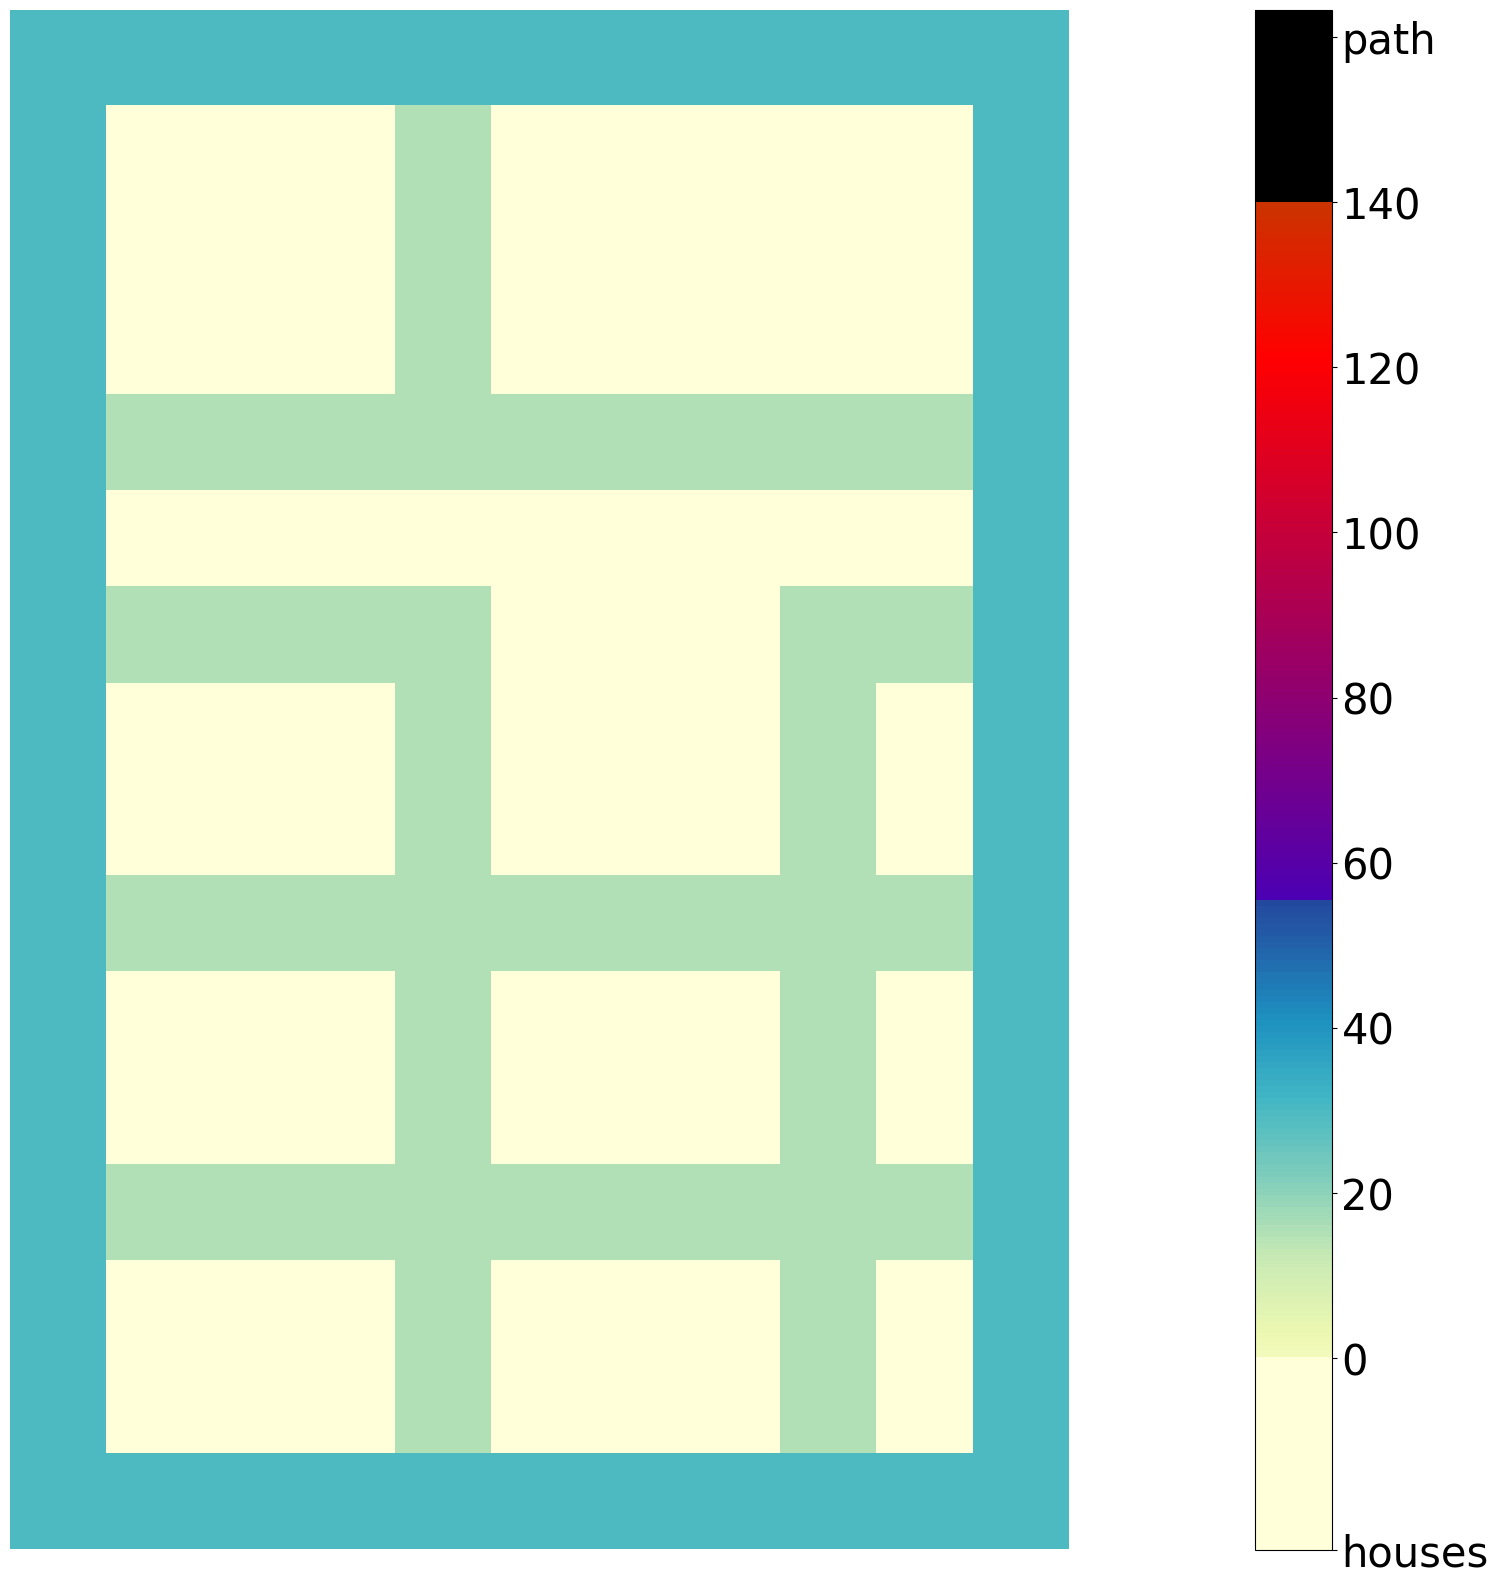

In [6]:
# If you put the map generated in a separate cell you can run multiple tests on the same map
map_ = Map(1)
map_.show()

The start is (9, 7), the end is (9, 6)
The path length was 1.0, the path is [(9, 7), (9, 6)].


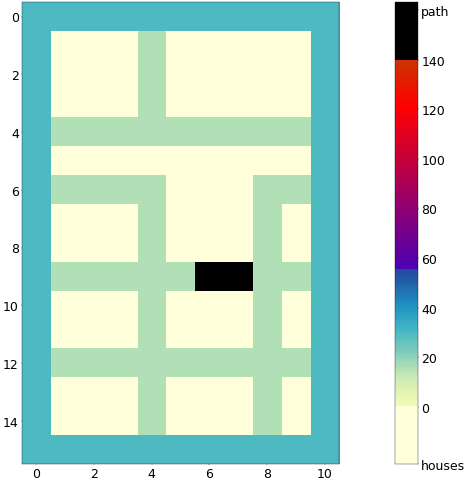

In [7]:
plt.matplotlib.rcParams['figure.dpi'] = max(30, map_.size ** 0.5 // 2)  # Number of pixels, therefore, the quality of the image. A large dpi is very slow.

# Generate a random start and end position in the grid for proper testing.
# start = (0,0)
# end =  (map_.shape[0]-1, map_.shape[1]-1)

# optional testing of different end and start
# should work without problems now
# use methods from grid_maker.py
start = map_.get_coordinate()
end = map_.get_coordinate()

print(f"The start is {start}, the end is {end}")
path, length = FloodFillSolver()(map_, start, end)
print(f"The path length was {length}, the path is {path}.")
map_.show(path, True)

## 1.1 Graph vs Grid

While the pathfinding works in the previous question it is not very efficient for a large grid or road network. Therefore, we can apply the principles of divide and conquer and dynamic programming to make it faster. So instead of finding the next possible action for each coordinate each time we run the solver, we will make a graph representation of the road network where we can save all possible next action for the coordinates that matter. When this graph is made we can use it to find the shortest path. Think about how this affects the algorithm and why it becomes faster. Does the complexity change or the state-space?

### 1.1.0 Making Graph Nodes from a Map

Here, we will make the graph from a given city grid. This graph should contain the following nodes:
 - All coordinates that are junctions.
 - All coordinates where you can change direction.
 - All coordinates that are a dead end.

All other coordinates should ***not*** be in the graph. To represent the graph we use an adjacency list where each node in the graph is a coordinate. 

So given the map below:

```python
road_grid = np.array([
    [30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30],
    [30,  0,  0,  0,  0, 15,  0,  0, 15,  0,  0,  0, 30],
    [30,  0,  0,  0,  0, 15,  0,  0, 15,  0,  0,  0, 30],
    [30,  0,  0,  0,  0, 15,  0,  0, 15,  0,  0,  0, 30],
    [30, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 30],
    [30,  0,  0,  0,  0, 15,  0,  0, 15,  0,  0,  0, 30],
    [30,  0,  0,  0,  0, 15,  0,  0, 15,  0,  0,  0, 30],
    [30,  0,  0,  0,  0, 15,  0,  0, 15,  0,  0,  0, 30],
    [30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30]
])
```

Without the edges, we get the following adjacency list:

```python
adjacency_list = {
    (0,  0): set(),
    (0,  5): set(),
    (0,  8): set(),
    (0, 12): set(),
    (4,  0): set(),
    (4,  5): set(),
    (4,  8): set(),
    (4, 12): set(),
    (8,  0): set(),
    (8,  5): set(),
    (8,  8): set(),
    (8, 12): set(),
}
```

In [8]:
%%execwritefile assignment2_{group}_notebook.py 10 -a -s

class GraphBluePrint():
    """
    You can ignore this class, it is just needed due to technicalities.
    """
    def find_nodes(self): pass
    def find_edges(self): pass
    
class Graph(GraphBluePrint):   
    """
    Attributes:
        :param adjacency_list: The adjacency list with the road distances and speed limit.
        :type adjacency_list: dict[tuple[int]: set[edge]], where an edge is a fictional datatype 
                              which is a tuple containing the datatypes tuple[int], int, float
        :param map: The map of the graph.
        :type map: Map
    """
    def __init__(self, map_, start=(0, 0)):
        """
        This function transforms any (city or lower) map into a graph representation.

        :param map_: The map that needs to be transformed.
        :type map_: Map
        :param start: The start node from which we will find all other nodes.
        :type start: tuple[int]
        """
        self.adjacency_list = {}
        self.map = map_
        self.start = start
        
        self.find_nodes()
        self.find_edges()  # This will be implemented in the next notebook cell
        
    def find_nodes(self):
        """
        This method contains a breadth-frist search algorithm to find all the nodes in the graph.
        So far, we called this method `step`. However, this class is more than just the search algorithm,
        therefore, we gave it a bit more descriptive name.

        Note, that we only want to find the nodes, so history does not need to contain a partial path (previous node).
        In `find_edges` (the next cell), we will add edges for each node.
        """
        queue = deque([self.start])
        history = {self.start}
        self.adjacency_list[self.start] = set()
        while queue:
            current = queue.popleft()
            for new_node in self.neighbour_coordinates(current):
                if new_node not in history:
                    queue.append(new_node)
                    history.add(new_node)
                    self.adjacency_list_add_node(new_node, self.neighbour_coordinates(new_node))
        
                    
    def adjacency_list_add_node(self, coordinate, actions):
        """
        This is a helper function for the breadth-first search algorithm to add a coordinate to the `adjacency_list` and
        to determine if a coordinate needs to be added to the `adjacency_list`.

        Reminder: A coordinate should only be added to the adjacency list if it is a corner, a crossing, or a dead end.
                  Adding the coordinate to the adjacency_list is equivalent to saying that it is a node in the graph.

        :param coordinate: The coordinate that might need to be added to the adjacency_list.
        :type coordinate: tuple[int]
        :param actions: The actions possible from this coordinate, an action is defined as an action in the coordinate state-space.
        :type actions: list[tuple[int]]
        """
        # changed this method to account for corners, start and end
        width, height = len(self.map[0]) - 1, len(self.map[:,1]) - 1
        edge_cases = [(0, 0), (0,  width), (height, 0), (height, width)]
        
        if len(actions) == 2:
            action1, action2 = tuple(actions)
        else:
            action1, action2 = (0, 0), (0, 0)

        if len(actions) > 2 or len(actions) == 1 or (action1[0] != action2[0] and action1[1] != action2[1]):
            self.adjacency_list[coordinate] = set()
        

                           
    def neighbour_coordinates(self, coordinate):
        """
        This method returns the next possible actions and is part of the breadth-first search algorithm.
        Similar to `find_nodes`, we often call this method `next_step`.
        
        :param coordinate: The current coordinate
        :type coordinate: tuple[int]
        :return: A list with possible next coordinates that can be visited from the current coordinate.
        :rtype: list[tuple[int]]  
        """
        moves = [(0, 1), (1, 0), (0, -1), (-1, 0)]
        return [(coordinate[0] + move[0], coordinate[1] + move[1]) for move in moves
                if 0 <= coordinate[0] + move[0] < self.map.shape[0] and
                0 <= coordinate[1] + move[1] < self.map.shape[1] and
                self.map[coordinate[0] + move[0], coordinate[1] + move[1]] != 0]
    
    def __repr__(self):
        """
        This returns a representation of a graph.

        :return: A string representing the graph object.
        :rtype: str
        """
        # You can change this to anything you like, such that you can easily print a Graph object. An example is already given.
        return repr(dict(sorted(self.adjacency_list.items()))).replace("},", "},\n")

    def __getitem__(self, key):
        """
        A magic method that makes using keys possible.
        This makes it possible to use self[node] instead of self.adjacency_list[node]

        :return: The nodes that can be reached from the node `key`.
        :rtype: set[tuple[int]]
        """
        return self.adjacency_list[key]

    def __contains__(self, key):
        """
        This magic method makes it possible to check if a coordinate is in the graph.

        :return: This returns if the coordinate is in the graph.
        :rtype: bool
        """
        return key in self.adjacency_list

    def get_random_node(self):
        """
        This returns a random node from the graph.
        
        :return: A random node
        :rtype: tuple[int]
        """
        return tuple(RNG.choice(list(self.adjacency_list)))
        
    def show_coordinates(self, size=5, color='k'):
        """
        If this method is used before another method that does a plot, it will be plotted on top.

        :param size: The size of the dots, default to 5
        :type size: int
        :param color: The Matplotlib color of the dots, defaults to black
        :type color: string
        """
        nodes = self.adjacency_list.keys()
        plt.plot([n[1] for n in nodes], [n[0] for n in nodes], 'o', color=color, markersize=size)        

    def show_edges(self, width=0.05, color='r'):
        """
        If this method is used before another method that does a plot, it will be plotted on top.
        
        :param width: The width of the arrows, default to 0.05
        :type width: float
        :param color: The Matplotlib color of the arrows, defaults to red
        :type color: string
        """
        for node, edge_list in self.adjacency_list.items():
            for next_node,_,_ in edge_list:
                plt.arrow(node[1], node[0], (next_node[1] - node[1])*0.975, (next_node[0] - node[0])*0.975, color=color, length_includes_head=True, width=width, head_width=4*width)


Appending to assignment2_3893995_4003748_notebook.py


### Test your code

Below, you can test your algorithm. Make sure that you test various road grids and that your algorithm works for all of them. To give you a head start a very limited test is given.

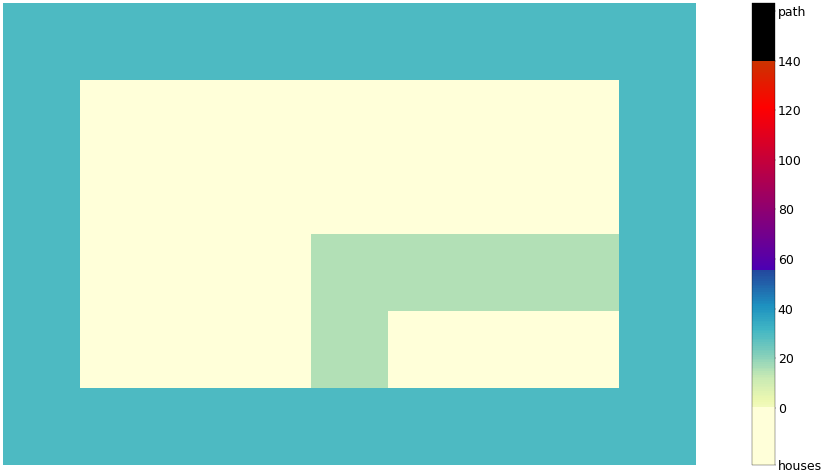

width of the map is 9 height is 6


In [9]:
# If you put the map generated in a separate cell you can run multiple tests on the same map
map_ = Map(1, (1, 1))
map_.show()
print(f"width of the map is {len(map_[0])} height is {len(map_[:,0])}")

{(0, 0): set(), (5, 0): set(), (0, 8): set(), (5, 4): set(), (3, 8): set(), (3, 4): set(), (5, 8): set()}


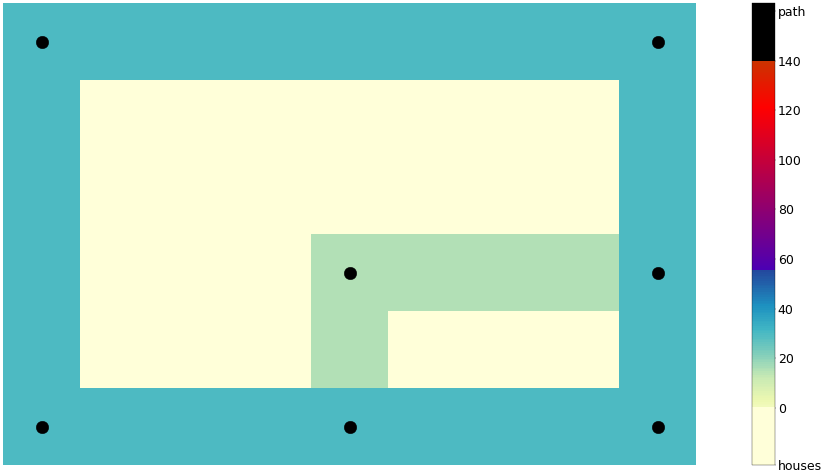

In [10]:
plt.matplotlib.rcParams['figure.dpi'] = max(30, map_.size ** 0.5 // 2)  # Number of pixels, therefore, the quality of the image. A large dpi is very slow.

graph = Graph(map_)
graph.show_coordinates(size=30, color="k")
print(graph.adjacency_list)
map_.show()

### 1.1.1 Making a Graph from a Map

To represent the graph we use an adjacency list, however, for the edges, we do not only store the connecting node but also the distance and speed limit. For now, we do not need the speed limit. Each coordinate has a length 1 and the speed limit is the integer in the grid. So, a piece of road between two nodes, i.e, the edge between two nodes has a distance equal to the number of coordinates between the nodes and the speed limit is the mode of all the speed limits of the coordinates. You can assume that the speed limit does not change for one road section. Only at the nodes itself can the speed limit change.

So given the map below:

```python
road_grid = np.array([
    [30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30],
    [30,  0,  0,  0,  0, 15,  0,  0, 15,  0,  0,  0, 30],
    [30,  0,  0,  0,  0, 15,  0,  0, 15,  0,  0,  0, 30],
    [30,  0,  0,  0,  0, 15,  0,  0, 15,  0,  0,  0, 30],
    [30, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 30],
    [30,  0,  0,  0,  0, 15,  0,  0, 15,  0,  0,  0, 30],
    [30,  0,  0,  0,  0, 15,  0,  0, 15,  0,  0,  0, 30],
    [30,  0,  0,  0,  0, 15,  0,  0, 15,  0,  0,  0, 30],
    [30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30]
])
```

We get the following adjacency list:

```python
adjacency_list = {
    (0,  0): {((0,5), 5, 30),  ((4,0), 4, 30)},
    (0,  5): {((0,0), 5, 30),  ((0,8), 3, 30),  ((4,5), 4, 15)},
    (0,  8): {((0,5), 3, 30),  ((0,12), 4, 30), ((4,8), 4, 15)},
    (0, 12): {((0,8), 4, 30),  ((4,12), 4, 30)},
    (4,  0): {((0,0), 4, 30),  ((4,5), 5, 15),  ((8,0), 4, 30)},
    (4,  5): {((0,5), 4, 15),  ((4,8), 3, 15),  ((8,5), 4, 15),  ((4,0), 5, 15)},
    (4,  8): {((0,8), 4, 15),  ((4,12), 4, 15), ((8,8), 4, 15),  ((4,5), 3, 15)},
    (4, 12): {((0,12), 4, 30), ((8,12), 4, 30), ((4,8), 4, 15)},
    (8,  0): {((8,5), 5, 30),  ((4,0), 4, 30)},
    (8,  5): {((8,0), 5, 30),  ((8,8), 3, 30),  ((4,5), 4, 15)},
    (8,  8): {((8,5), 3, 30),  ((8,12), 4, 30), ((4,8), 4, 15)},
    (8, 12): {((8,8), 4, 30),  ((4,12), 4, 30)}
}
```

We represent the following graph:

<img src="graph_city.png" alt="drawing" width="500"/>

***Note, that this road network has no one-direction roads.***

In [11]:
%%execwritefile assignment2_{group}_notebook.py 15 -a -s -c

class Graph(Graph):   
    def find_edges(self):
        """
        This method does a depth-first/brute-force search for each node to find the edges of each node.
        """
        # reworked this completely, should work now
        width, height = len(self.map[0]) - 1, len(self.map[:,1]) - 1
        for node in self.adjacency_list:
            node_edges = []
            for direction in [(0, 1), (1, 0), (0, -1), (-1, 0)]:
                # check if we are not outside of the grid by going to the next step
                # by either going to negative values or values higher than the grid size
                # if (node[0] == 0 and direction[0] == -1) or (node[1] == 0 and direction[1] == -1):
                #     continue
                # elif (node[0] == height and direction[0] == 1) or (node[1] == width and direction[1] == 1):
                #     continue
                # elif self.map[node[0] + direction[0]][node[1] + direction[1]] == 0:
                #     continue
                
                new_height, new_width = node[0] + direction[0], node[1] + direction[1]
                if new_width < 0 or new_height < 0 or new_width > width or new_height > height:
                    continue
                if not self.map[new_height][new_width]:
                    continue
                next_node, distance = self.find_next_node_in_adjacency_list(node, direction)
                speed_limit = self.map[next_node[0], next_node[1]]
                node_edges.append((next_node, distance, speed_limit))
            self.adjacency_list[node] = node_edges


    def find_next_node_in_adjacency_list(self, node, direction):
        """
        This is a helper method for find_edges to find a single edge given a node and a direction.

        :param node: The node from which we try to find its "neighboring node" NOT its neighboring coordinates.
        :type node: tuple[int]
        :param direction: The direction we want to search in this can only be 4 values (0, 1), (1, 0), (0, -1) or (-1, 0).
        :type direction: tuple[int]
        :return: This returns the first node in this direction and the distance.
        :rtype: tuple[int], int 
        """
        current_node = node
        distance = 0
        while True:
            distance += 1
            new_node = (current_node[0] + direction[0], current_node[1] + direction[1])
            if new_node in self.adjacency_list:
                return new_node, distance
            current_node = new_node

Appending to assignment2_3893995_4003748_notebook.py


### Test your code

Below, you can test your algorithm. Make sure that you test various road grids and that your algorithm works for all of them. To give you a head start a very limited test is given.

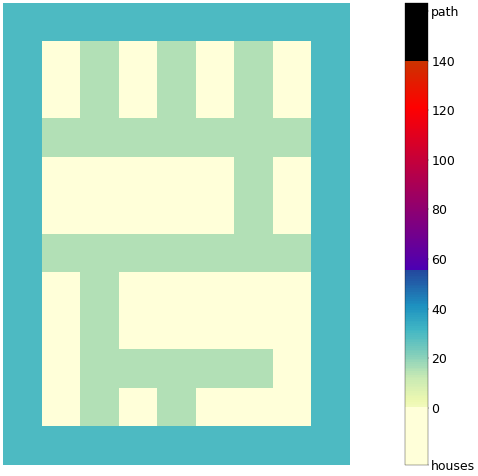

In [12]:
# If you put the map generated in a separate cell you can run multiple tests on the same map
map_ = Map(1, (1, 5))
map_.show()

[[30. 30. 30. 30. 30. 30. 30. 30. 30.]
 [30.  0. 15.  0. 15.  0. 15.  0. 30.]
 [30.  0. 15.  0. 15.  0. 15.  0. 30.]
 [30. 15. 15. 15. 15. 15. 15. 15. 30.]
 [30.  0.  0.  0.  0.  0. 15.  0. 30.]
 [30.  0.  0.  0.  0.  0. 15.  0. 30.]
 [30. 15. 15. 15. 15. 15. 15. 15. 30.]
 [30.  0. 15.  0.  0.  0.  0.  0. 30.]
 [30.  0. 15.  0.  0.  0.  0.  0. 30.]
 [30.  0. 15. 15. 15. 15. 15.  0. 30.]
 [30.  0. 15.  0. 15.  0.  0.  0. 30.]
 [30. 30. 30. 30. 30. 30. 30. 30. 30.]]
{(0, 0): [((0, 2), 2, 30.0), ((3, 0), 3, 30.0)], (0, 2): [((0, 4), 2, 30.0), ((3, 2), 3, 15.0), ((0, 0), 2, 30.0)], (3, 0): [((3, 2), 2, 15.0), ((6, 0), 3, 30.0), ((0, 0), 3, 30.0)], (0, 4): [((0, 6), 2, 30.0), ((3, 4), 3, 15.0), ((0, 2), 2, 30.0)], (3, 2): [((3, 4), 2, 15.0), ((3, 0), 2, 30.0), ((0, 2), 3, 30.0)], (0, 6): [((0, 8), 2, 30.0), ((3, 6), 3, 15.0), ((0, 4), 2, 30.0)], (6, 0): [((6, 2), 2, 15.0), ((11, 0), 5, 30.0), ((3, 0), 3, 30.0)], (3, 4): [((3, 6), 2, 15.0), ((3, 2), 2, 15.0), ((0, 4), 3, 30.0)], (0, 8): [((3

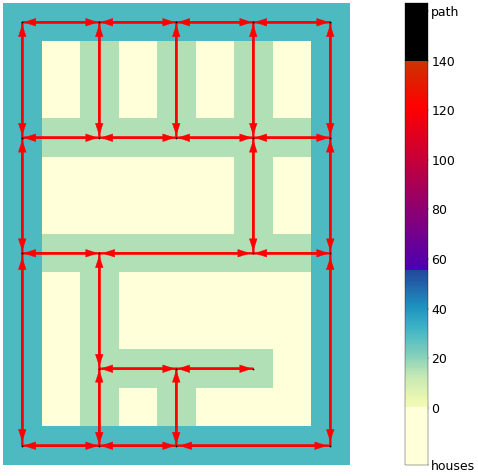

In [13]:
plt.matplotlib.rcParams['figure.dpi'] = max(30, map_.size ** 0.5 // 2)  # Number of pixels, therefore, the quality of the image. A large dpi is very slow.

graph = Graph(map_)
print(map_.grid)
print(graph.adjacency_list)
graph.show_coordinates(size=3, color="k")
graph.show_edges()
map_.show()


## 1.2 Graph Floodfill

Here, we will reimplement the flood-fill algorithm but now it must work on a graph instead of a grid. To save some time we use inherritance to copy-paste all the code of `FloodFillSolver` to `FloodFillSolverGraph`. Now, we only need to overwrite the `__call__` method and `next_step` method. Depending on how you implemented `find_path` you need to overwrite it or not. Make sure your distance is correct. You can also go back and make the method work for both classes if it doesn't work right now. If you want to overwrite the method uncomment the method and complete it. You do not need to change anything else. 

The theory says that BFS always gives the shortest state-space graph traversal path. So far, this worked out to also give the shortest path on our map. However, this is not the case anymore. Do some experiments using the `FloodFillSolverGraph` on different map levels, why does it not guarantee to give the shortest path on some levels but on others it does? What changed between floodfill on the grid vs floodfill on the graph?

In [14]:
%%execwritefile assignment2_{group}_notebook.py 120 -a -s 

class FloodFillSolverGraph(FloodFillSolver):
    """
    A class instance should at least contain the following attributes after being called:
        :param queue: A queue that contains all the nodes that need to be visited.
        :type queue: collections.deque
        :param history: A dictionary containing the coordinates that will be visited and as values the coordinate that lead to this coordinate.
        :type history: dict[tuple[int], tuple[int]]
    """
    def __call__(self, graph, source, destination):      
        """
        This method gives a shortest route through the grid from source to destination.
        You start at the source and the algorithm ends if you reach the destination, both nodes should be included in the path.
        A route consists of a list of nodes (which are coordinates).

        Hint: The history is already given as a dictionary with as keys the node in the state-space graph and
        as values the previous node from which this node was visited.

        :param graph: The graph that represents the map.
        :type graph: Graph
        :param source: The node where the path starts.
        :type source: tuple[int]
        :param destination: The node where the path ends.
        :type destination: tuple[int]
        :return: The shortest route, which consists of a list of nodes and the length of the route.
        :rtype: list[tuple[int]], float
        """ 
        #IMPORTANT   
        # this code works if we consider the output distance to be the number of
        # nodes in a path, and not the distance in the tuples of the adjacency list
        # need to ask during the workgroup
        self.queue = deque([source])
        self.history = {source: None}
        self.graph = graph
        self.destination = destination
        self.main_loop()
        return self.find_path()

    def find_path(self):
        """
        This method finds the shortest paths between the source node and the destination node.
        It also returns the length of the path. 
        
        Note, that going from one coordinate to the next has a length of 1.
        For example: The distance between coordinates (0,0) and (0,1) is 1 and 
                     The distance between coordinates (3,0) and (3,3) is 3. 

        The distance is the Manhattan distance of the path.

        :return: A path that is the optimal route from source to destination and its length.
        :rtype: list[tuple[int]], float
        """
        if self.destination not in self.history:
            return [], 0.0
        path = []
        current = self.destination
        prev = self.destination
        length = 0.0
        while current:
            path.append(current)
            length += np.sqrt((current[0] - prev[0])**2 + (current[1] - prev[1])**2)
            prev = current
            current = self.history.get(current)
        path.reverse()
        return path, length

    def next_step(self, node):
        """
        This method returns the next possible actions.

        :param node: The current node
        :type node: tuple[int]
        :return: A list with possible next nodes that can be visited from the current node.
        :rtype: list[tuple[int]]  
        """
        return [item[0] for item in self.graph.adjacency_list[node]]


Appending to assignment2_3893995_4003748_notebook.py


### Test your code

Below, you can test your algorithm. Make sure that you test various road grids and that your algorithm works for all of them. To give you a head start a very limited test is given.

***Do not forget to do the experiments described above***

In [15]:
# If you put the map generated in a separate cell you can run multiple tests on the same map
map_ = Map(1, (1,5))  # Now you can also solve the levels 1, 2, 3 and 4 

The start is (14, 6), the end is (0, 0)
The path length was 20.0, the path is [(14, 6), (14, 2), (14, 0), (11, 0), (7, 0), (4, 0), (0, 0)].


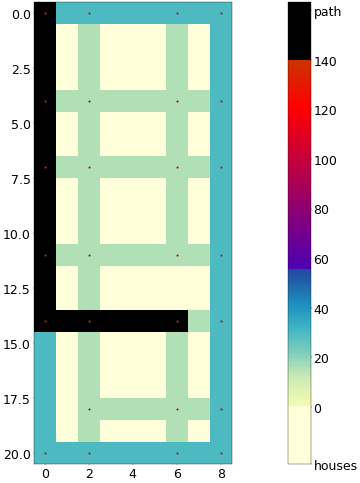

In [16]:
plt.matplotlib.rcParams['figure.dpi'] = max(30, map_.size ** 0.5 // 2)  # Number of pixels, therefore, the quality of the image. A large dpi is very slow.

graph = Graph(map_)
start = (0,0)
end = (map_.shape[0]-1, map_.shape[1]-1)

# optional tests 
nodes_in_graph = list(graph.adjacency_list.keys())
rand_index1, rand_index2 = np.random.choice(len(nodes_in_graph)), np.random.choice(len(nodes_in_graph))
start = nodes_in_graph[rand_index1]
end = nodes_in_graph[rand_index2]


path, length = FloodFillSolverGraph()(graph, start, end)


print(f"The start is {start}, the end is {end}")
print(f"The path length was {length}, the path is {path}.")
graph.show_coordinates(color='r', size=4)
map_.show(path, True)


## 1.3 BFS with Priority Queue

As you discovered in the previous task, a basic floodfill or BFS does not work on a more general graph compared to a grid. Here, we will update the algorithm such that it works in the more general case. There are many names for such an algorithm. However, in this assignment, we are only interested in why and how it works. The main problem of a simple BFS is that it does not take into account the cost of going from one node to the next. In [1.0 Grid Floodfill ](#1.0-Grid-Floodfill,-a-Basic-BFS) this was not a problem as the cost was 1 for all steps. However, in a graph, the cost between two neighboring nodes can be anything because it is the distance between the two nodes. Therefore, we should not explore the state-space graph using a queue (first in first out) but a priority queue where we explore the nodes with the shortest distance to our source node.

Think about why this solves our problems. How does changing the order of visiting nodes guarantee that when you reach the destination node you can stop because you found the shortest path?

***Note, that we know that there are fast implementations in Python for a priority queue. However, we want to see that you understand how a priority queue works. Therefore you need to use a list, that you update appropriately.***

In [17]:
%%execwritefile assignment2_{group}_notebook.py 130 -a -s 

class BFSSolverShortestPath():
    """
    A class instance should at least contain the following attributes after being called:
        :param priorityqueue: A priority queue that contains all the nodes that need to be visited including the distances it takes to reach these nodes.
        :type priorityqueue: list[tuple[tuple(int), float]]
        :param history: A dictionary containing the nodes that will be visited and 
                        as values the node that lead to this node and
                        the distance it takes to get to this node.
        :type history: dict[tuple[int], tuple[tuple[int], int]]
    """   
    def __call__(self, graph, source, destination):      
        """
        This method gives the shortest route through the graph from the source to the destination node.
        You start at the source node and the algorithm ends if you reach the destination node, 
        both nodes should be included in the path.
        A route consists of a list of nodes (which are coordinates).

        :param graph: The graph that represents the map.
        :type graph: Graph
        :param source: The node where the path starts
        :type source: tuple[int] 
        :param destination: The node where the path ends
        :type destination: tuple[int]
        :param vehicle_speed: The maximum speed of the vehicle.
        :type vehicle_speed: float
        :return: The shortest route and the time it takes. The route consists of a list of nodes.
        :rtype: list[tuple[int]], float
        """       
        self.priorityqueue = [(source, 0)]
        self.history = {source: (None, 0)}
        self.destination = destination
        self.graph = graph
        self.main_loop()
        return self.find_path()


    def find_path(self):
        """
        This method finds the shortest paths between the source node and the destination node.
        It also returns the length of the path. 
        
        Note, that going from one node to the next has a length of 1.

        :return: A path that is the optimal route from source to destination and its length.
        :rtype: list[tuple[int]], float
        """
        if self.destination not in self.history:
            return [], 0.0
        path = []
        current = self.destination
        prev = self.destination
        length = 0.0
        while current:
            path.append(current)
            next_item = self.history.get(current)
            # length += next_item[1]
            prev = current
            current = next_item[0]
        path.reverse()
        return path, self.history[self.destination][1]

    def main_loop(self):
        """
        This method contains the logic of the flood-fill algorithm for the shortest path problem.

        It does not have any inputs nor outputs. 
        Hint, use object attributes to store results.
        """
        while self.priorityqueue:
            current, current_distance = self.priorityqueue.pop(0)
            if self.base_case(current):
                return
            for new_node in self.next_step(current):
                current_distance = np.sqrt((current[0] - new_node[0])**2 + (current[1] - new_node[1])**2)
                self.step(current, new_node, current_distance, graph.map.grid[new_node[0]][new_node[1]])

    def base_case(self, node):
        """
        This method checks if the base case is reached.

        :param node: The current node
        :type node: tuple[int]
        :return: Returns True if the base case is reached.
        :rtype: bool
        """
        return node == self.destination

    def new_cost(self, previous_node, distance, speed_limit):
        """
        This is a helper method that calculates the new cost to go from the previous node to
        a new node with a distance and speed_limit between the previous node and new node.

        For now, speed_limit can be ignored.

        :param previous_node: The previous node that is the fastest way to get to the new node.
        :type previous_node: tuple[int]
        :param distance: The distance between the node and new_node
        :type distance: int
        :param speed_limit: The speed limit on the road from node to new_node. 
        :type speed_limit: float
        :return: The cost to reach the node.
        :rtype: float
        """
   
        return distance + self.history[previous_node][1]

    def step(self, node, new_node, distance, speed_limit):
        """
        One step in the BFS algorithm. For now, speed_limit can be ignored.

        :param node: The current node
        :type node: tuple[int]
        :param new_node: The next node that can be visited from the current node
        :type new_node: tuple[int]
        :param distance: The distance between the node and new_node
        :type distance: int
        :param speed_limit: The speed limit on the road from node to new_node. 
        :type speed_limit: float
        """
        if new_node not in self.history:
            self.priorityqueue.append((new_node, self.new_cost(node, distance, speed_limit)))
            self.history[new_node] = (node, self.new_cost(node, distance, speed_limit))
    
    def next_step(self, node):
        """
        This method returns the next possible actions.

        :param node: The current node
        :type node: tuple[int]
        :return: A list with possible next nodes that can be visited from the current node.
        :rtype: list[tuple[int]]  
        """
        return [item[0] for item in self.graph.adjacency_list[node]]   

Appending to assignment2_3893995_4003748_notebook.py


### Test your code

Below, you can test your algorithm. Make sure that you test various road grids and that your algorithm works for all of them. To give you a head start a very limited test is given.

The path [(0, 0), (0, 5), (0, 11), (6, 11), (11, 11), (11, 18), (13, 18), (16, 18), (20, 18), (20, 25)] has a distance of: 45.0


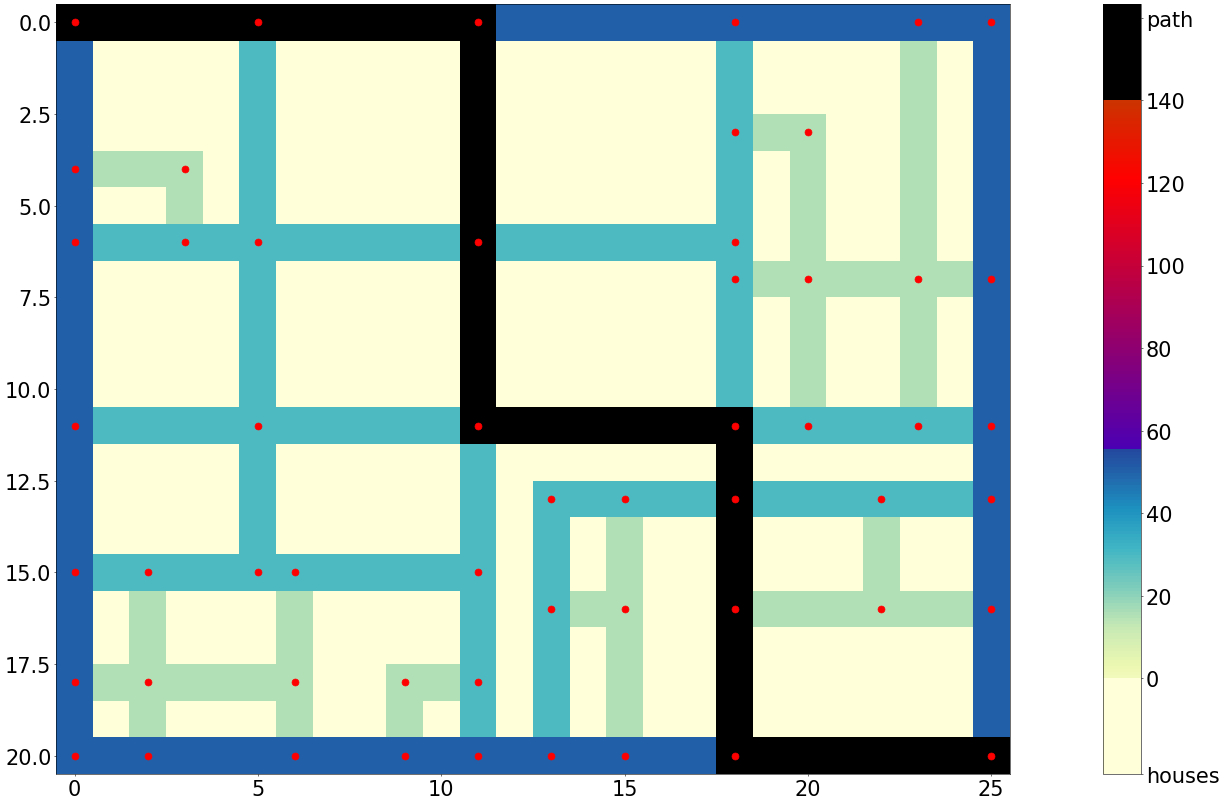

In [18]:
# If you put the map generated in a separate cell you can run multiple tests on the same map
map_ = Map(2, (1,3))

# Map 5 cannot be shown

plt.matplotlib.rcParams['figure.dpi'] = max(50, map_.size ** 0.5 // 2)  # Number of pixels, therefore, the quality of the image. A large dpi is very slow.

graph = Graph(map_)
start = (0,0)
end = (map_.shape[0]-1, map_.shape[1]-1)

path, distance = BFSSolverShortestPath()(graph, start, end)
print(f"The path {path} has a distance of: {distance}")
graph.show_coordinates(color='r', size=10)
# graph.show_edges()
map_.show(path, axis=True)


## 2.0 Fastest Path with BFS

So far we focussed on the shortest path but often if you use a route planner you are not interested in the shortest path but in the fastest path. So, using faster roads that are a bit longer can give a better solution than using roads with a low speed limit. However, it also depends on the maximum speed of your vehicle, it is useless to take roads with a higher speed limit if you can not take advantage of it. Below, you will implement again a BFS algorithm that incorporates these changes. Note, that a more general fastest path algorithm can actually also give the shortest path with the correct input.

***Hint: This algorithm should almost be a copy-paste from the previous BFS with the only change of what optimal is. Therefore, we will use inheritance to save you the trouble of copy-pasting.***


In [19]:
%%execwritefile assignment2_{group}_notebook.py 200 -a -s 

class BFSSolverFastestPath(BFSSolverShortestPath):
    """
    A class instance should at least contain the following attributes after being called:
        :param priorityqueue: A priority queue that contains all the nodes that need to be visited 
                              including the time it takes to reach these nodes.
        :type priorityqueue: list[tuple[tuple[int], float]]
        :param history: A dictionary containing the nodes that will be visited and 
                        as values the node that lead to this node and
                        the time it takes to get to this node.
        :type history: dict[tuple[int], tuple[tuple[int], float]]
    """   
    def __call__(self, graph, source, destination, vehicle_speed):      
        """
        This method gives a fastest route through the grid from source to destination.

        This is the same as the `__call__` method from `BFSSolverShortestPath` except that 
        we need to store the vehicle speed. 
        
        Here, you can see how we can overwrite the `__call__` method but 
        still use the `__call__` method of BFSSolverShortestPath using `super`.
        """
        self.vehicle_speed = vehicle_speed
        return super(BFSSolverFastestPath, self).__call__(graph, source, destination)

    def new_cost(self, previous_node, distance, speed_limit):
        """
        This is a helper method that calculates the new cost to go from the previous node to
        a new node with a distance and speed_limit between the previous node and new node.

        Use the `speed_limit` and `vehicle_speed` to determine the time/cost it takes to go to
        the new node from the previous_node and add the time it took to reach the previous_node to it..

        :param previous_node: The previous node that is the fastest way to get to the new node.
        :type previous_node: tuple[int]
        :param distance: The distance between the node and new_node
        :type distance: int
        :param speed_limit: The speed limit on the road from node to new_node. 
        :type speed_limit: float
        :return: The cost to reach the node.
        :rtype: float
        """
        min_speed = min(speed_limit, self.vehicle_speed)
        time_to_new_node = distance / min_speed
        total_time = time_to_new_node + self.history[previous_node][1]

        return total_time


Appending to assignment2_3893995_4003748_notebook.py


### Test your code

Below, you can test your algorithm. Make sure that you test various road grids and that your algorithm works for all of them. To give you a head start a very limited test is given.

The estimate travel time for the path is: 0.43333333333333335
The path [(0, 0), (0, 6), (0, 9), (0, 13)] has a distance of: 13.0


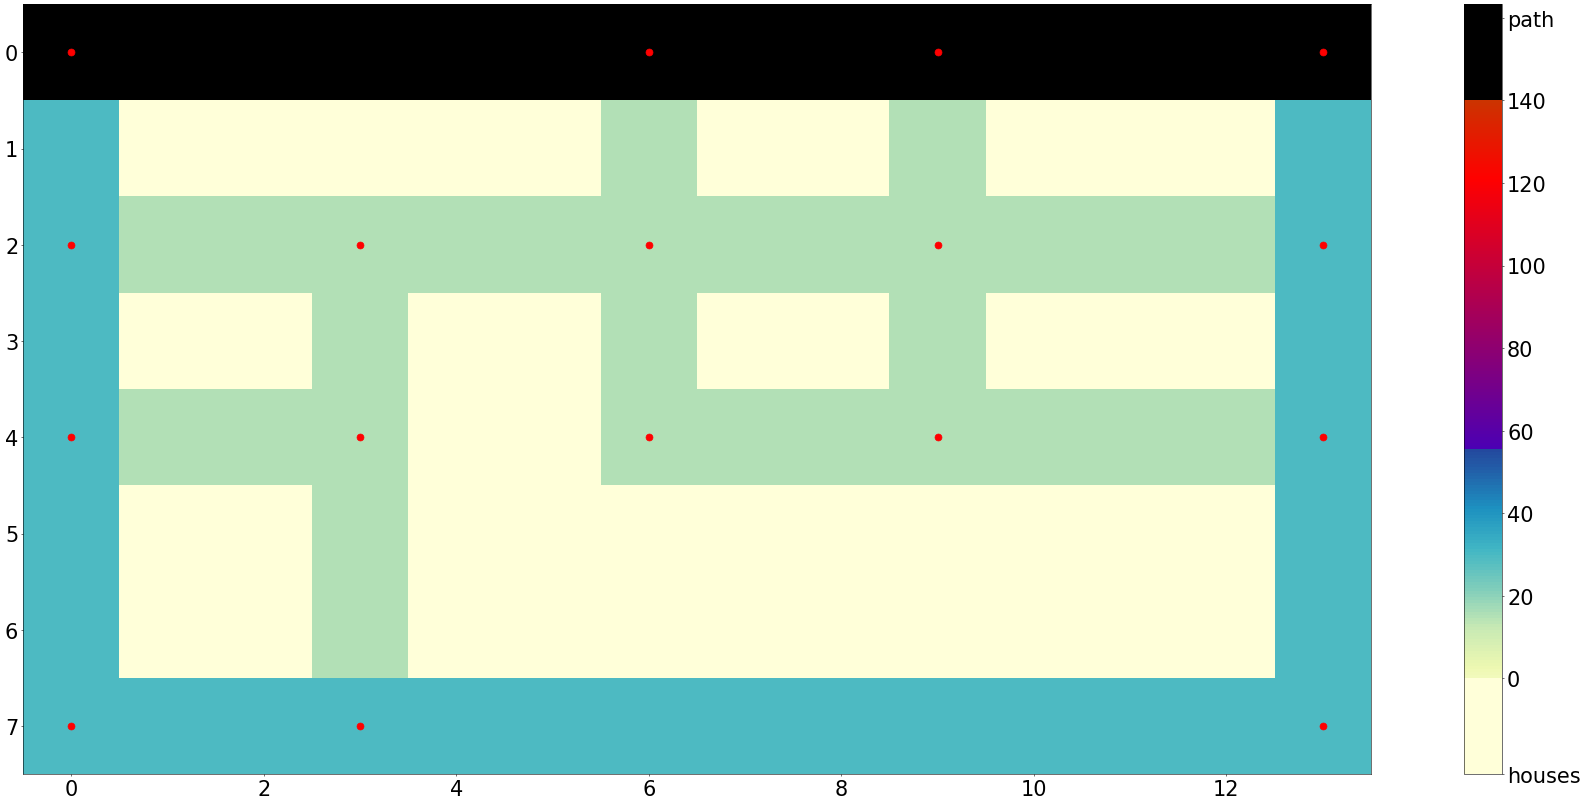

In [20]:
# If you put the map generated in a separate cell you can run multiple tests on the same map
map_ = Map(1, (1,3))

plt.matplotlib.rcParams['figure.dpi'] = max(50, map_.size ** 0.5 // 2)  # Number of pixels, therefore, the quality of the image. A large dpi is very slow.

graph = Graph(map_)
start = (0,0)
end = (map_.shape[0]-1, map_.shape[1]-1)
end = graph.get_random_node()
vehicle_speed = 180

path, time = BFSSolverFastestPath()(graph, start, end, vehicle_speed)
print(f"The estimate travel time for the path is: {time}")
path, distance = BFSSolverShortestPath()(graph, start, end)
print(f"The path {path} has a distance of: {distance}")
graph.show_coordinates(color='r', size=10)
map_.show(path, True)


## 2.1 From Coordinate to Node

In this question, we will restore some functionality that we lost with the graph representation. In the first question, we could go from any coordinate on the map to any other coordinate. When we started using graphs we lost that ability because not all coordinates were in the graph and therefore we could only find paths between nodes. We do not want to at all the coordinates to the graph because we would lose our speed advantage. So, we could use the idea of divide and conquer where we have two path-finding algorithms and then connect both solutions to get a final path. In this question, we will make an algorithm to find the closest nodes of any given coordinate.

Note, that each coordinate should only have 1 or 2 closest nodes.

On a programming note, instead of implementing a class as we have done so far, we will use a function for this algorithm. The reason is that it is a small and not very complex algorithm therefore a function will suffice.

***Hint: Sometimes a problem requires a tailor-made algorithm. In this case, we could use a floodfill on the grid with certain base case conditions, however, this is not needed at all. Think about when a coordinate is node and could it be possible that you make a turn to find a node from a coordinate?***

In [21]:
%%execwritefile assignment2_{group}_notebook.py 210 -a -s 

def coordinate_to_node(map_, graph, coordinate):
    """
    This function finds a path from a coordinate to its closest nodes.
    A closest node is defined as the first node you encounter if you go a certain direction.
    This means that unless the coordinate is a node, you will need to find two closest nodes.
    If the coordinate is a node then return a list with only the coordinate itself.
    :param map_: The map of the graph
    :type map_: Map
    :param graph: A Graph of the map
    :type graph: Graph
    :param coordinate: The coordinate from which we want to find the closest node in the graph
    :type coordinate: tuple[int]
    :return: This returns a list of closest nodes which contains either 1 or 2 nodes.
    :rtype: list[tuple[int]]
    """
    closest_nodes = []
    if coordinate in graph.adjacency_list:
        return [coordinate]

    width, height = len(graph.map[0]) - 1, len(graph.map[:,1]) - 1 
    for direction in [(1, 0), (-1, 0), (0, 1), (0, -1)]:
        new_height, new_width = coordinate[0] + direction[0], coordinate[1] + direction[1]
        if new_width < 0 or new_height < 0 or new_width > width or new_height > height:
            continue
        if not graph.map[new_height][new_width]:
            continue
        closest_nodes.append(find_node_in_direction(graph, (new_height, new_width), direction))
    return closest_nodes

# added this helper function
def find_node_in_direction(graph, node, direction):
    current = node
    while True:
        if current in graph.adjacency_list:
            return current
        current = (current[0] + direction[0], current[1] + direction[1])


Appending to assignment2_3893995_4003748_notebook.py


### Test your code

Below, you can test your algorithm. Make sure that you test various road grids and that your algorithm works for all of them. To give you a head start a very limited test is given.

the coordinate is (6, 5), the closesest nodes are [(6, 5)]


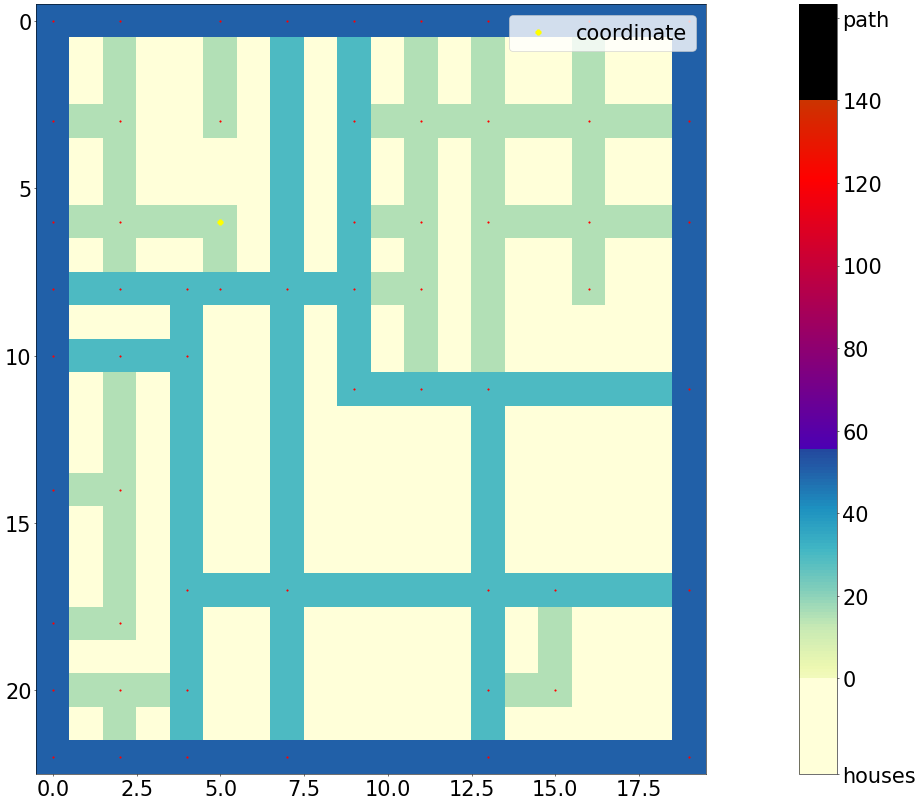

The coordinate is (6, 5), the closest nodes are [(6, 7), (6, 3)]


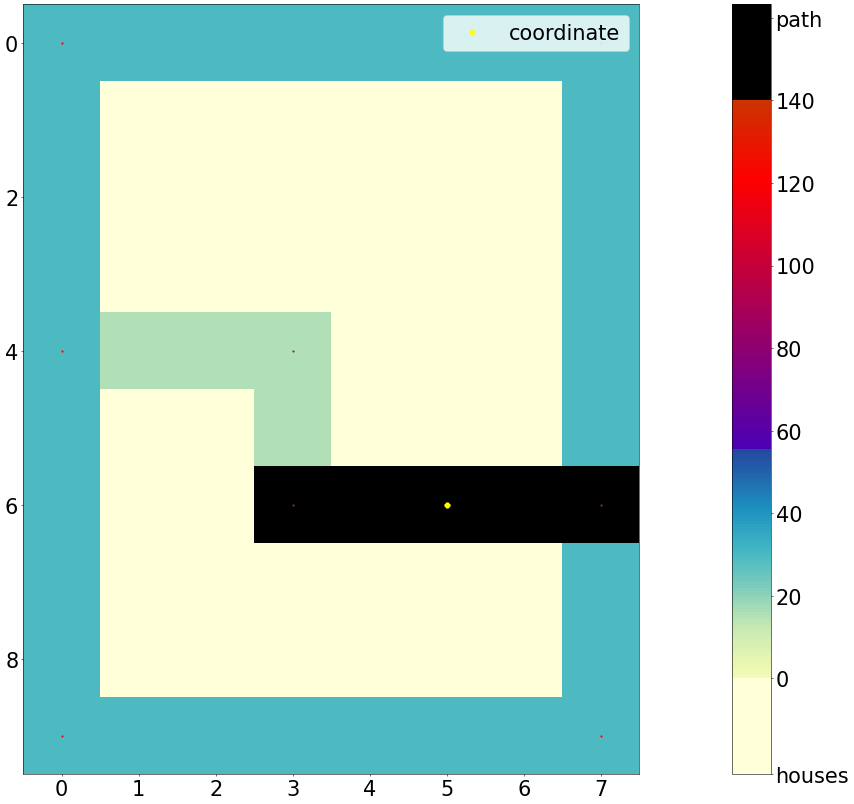

The coordinate is (0, 2), the closest nodes are [(0, 7), (0, 0)]


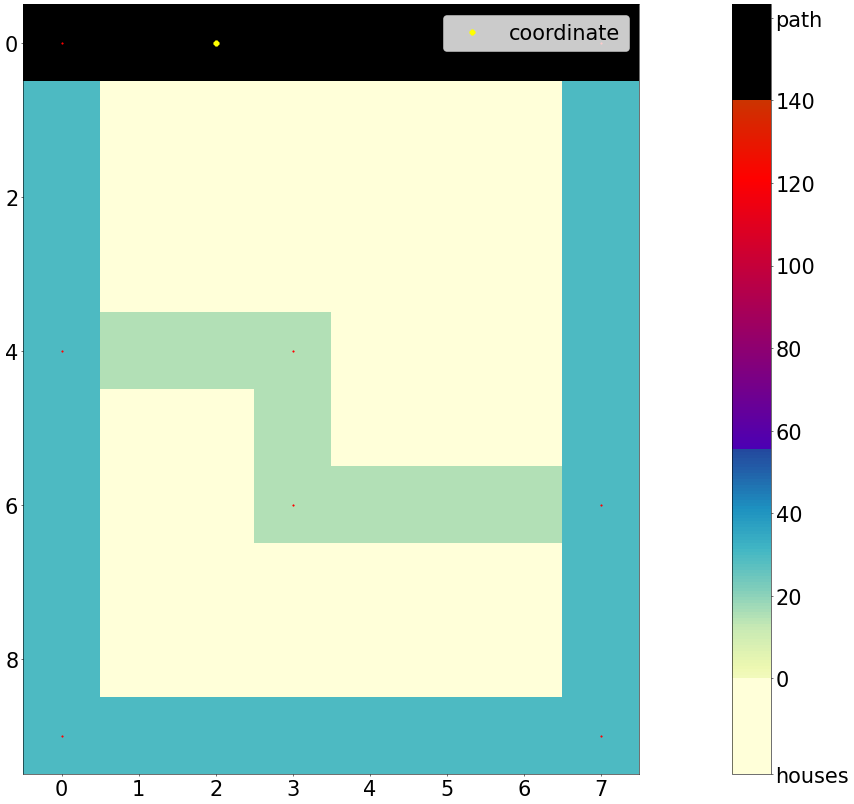

The coordinate is (11, 5), the closest nodes are [(11, 10), (11, 4)]


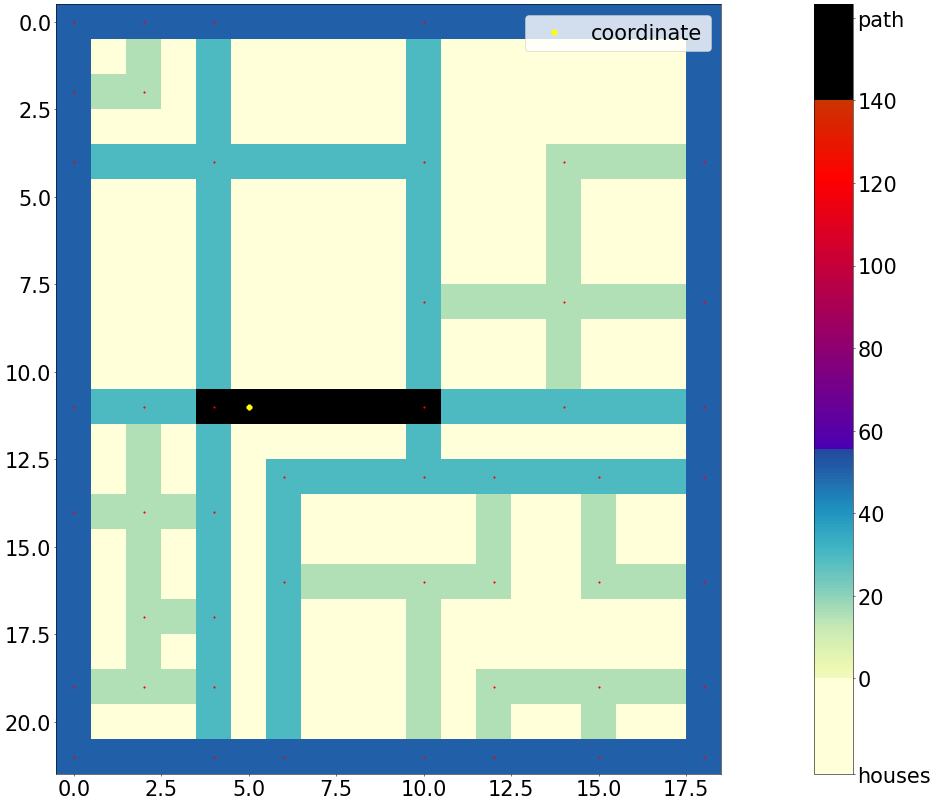

The coordinate is (20, 10), the closest nodes are [(21, 10), (16, 10)]


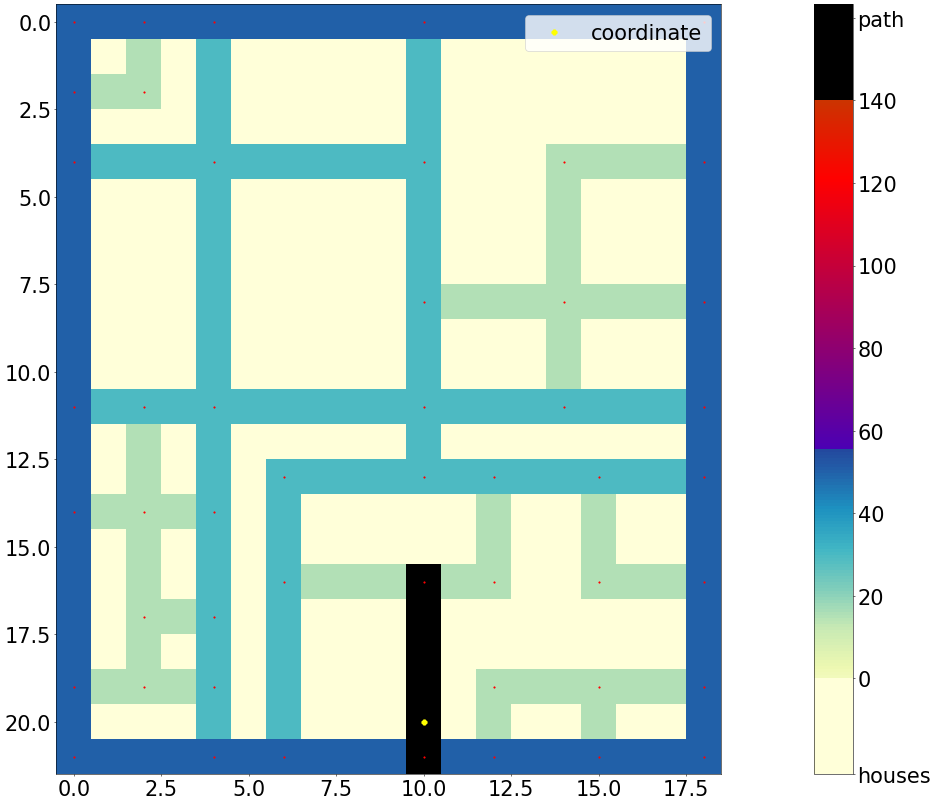

The coordinate is (0, 7), the closest nodes are [(0, 7)]


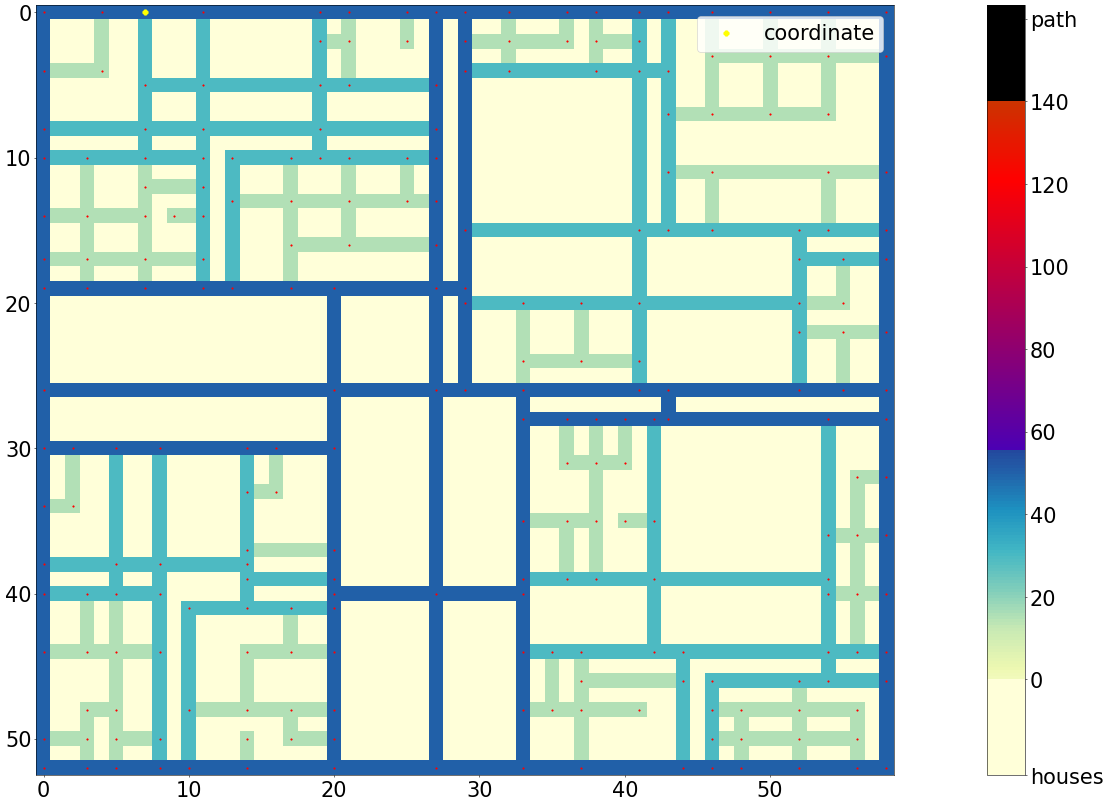

The coordinate is (18, 41), the closest nodes are [(20, 41), (15, 41)]


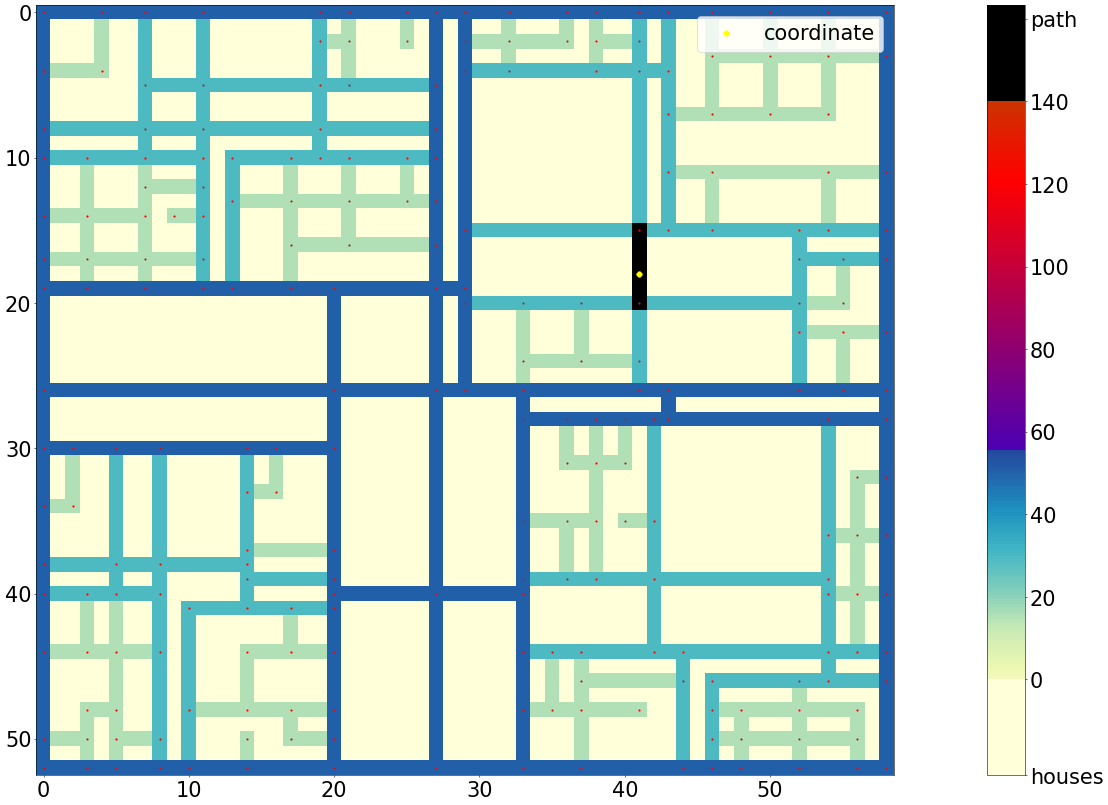

The coordinate is (56, 67), the closest nodes are [(57, 67), (53, 67)]


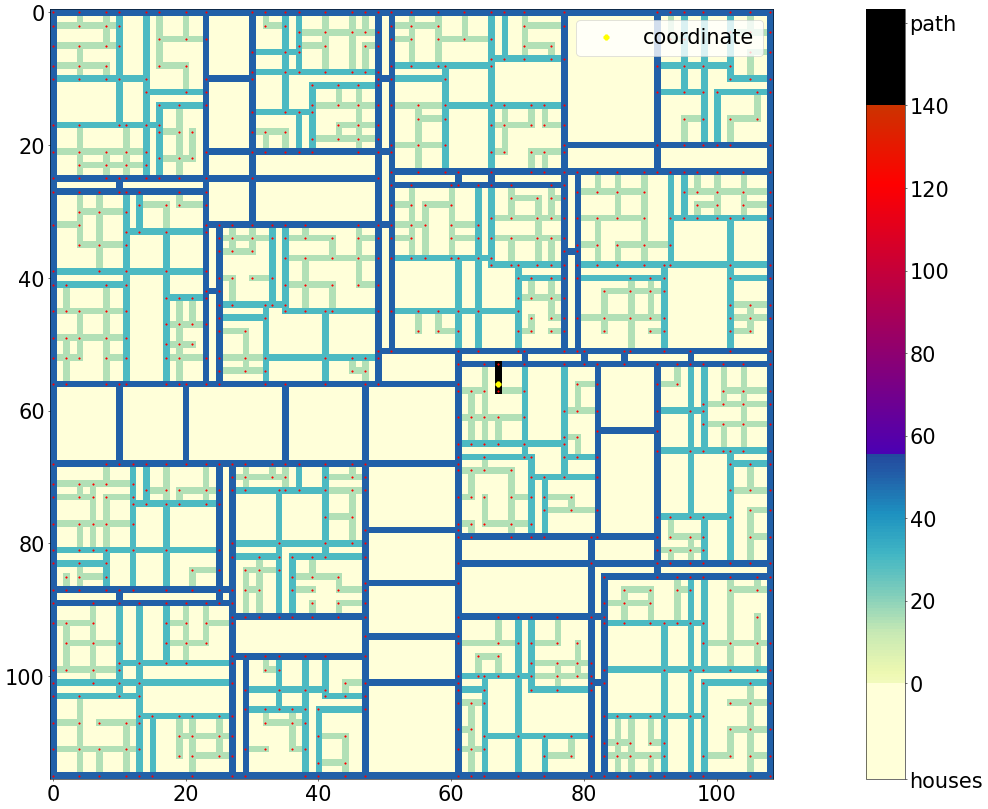

The coordinate is (63, 71), the closest nodes are [(65, 71), (61, 71)]


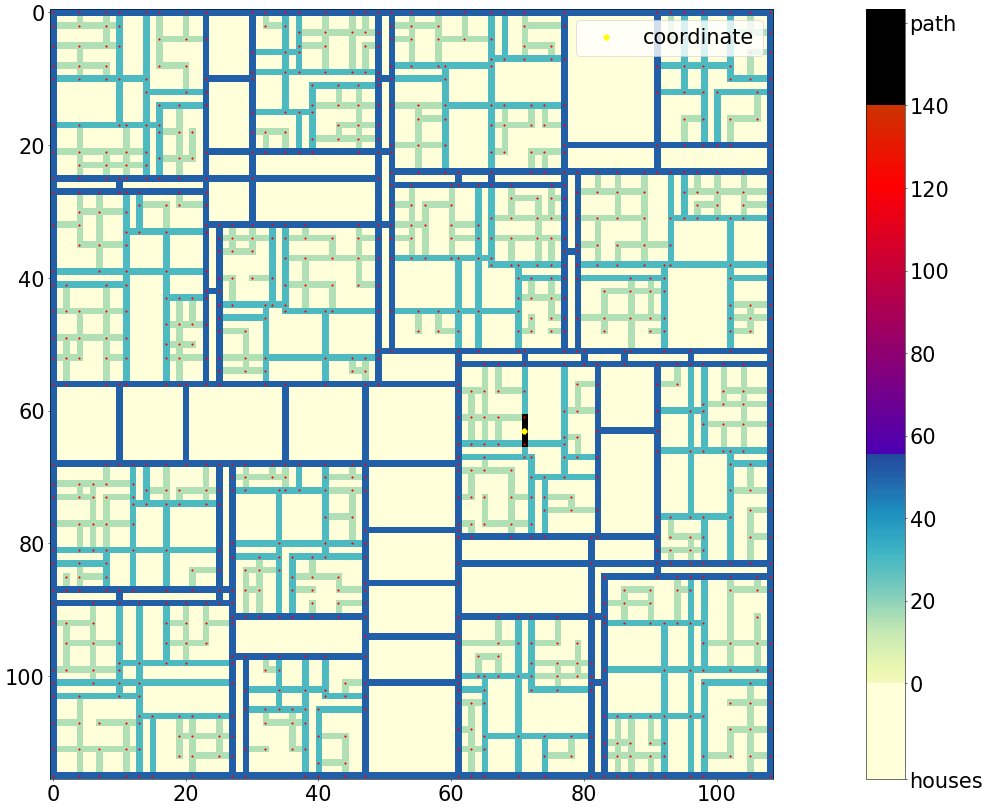

The coordinate is (0, 8), the closest nodes are [(0, 61), (0, 0)]


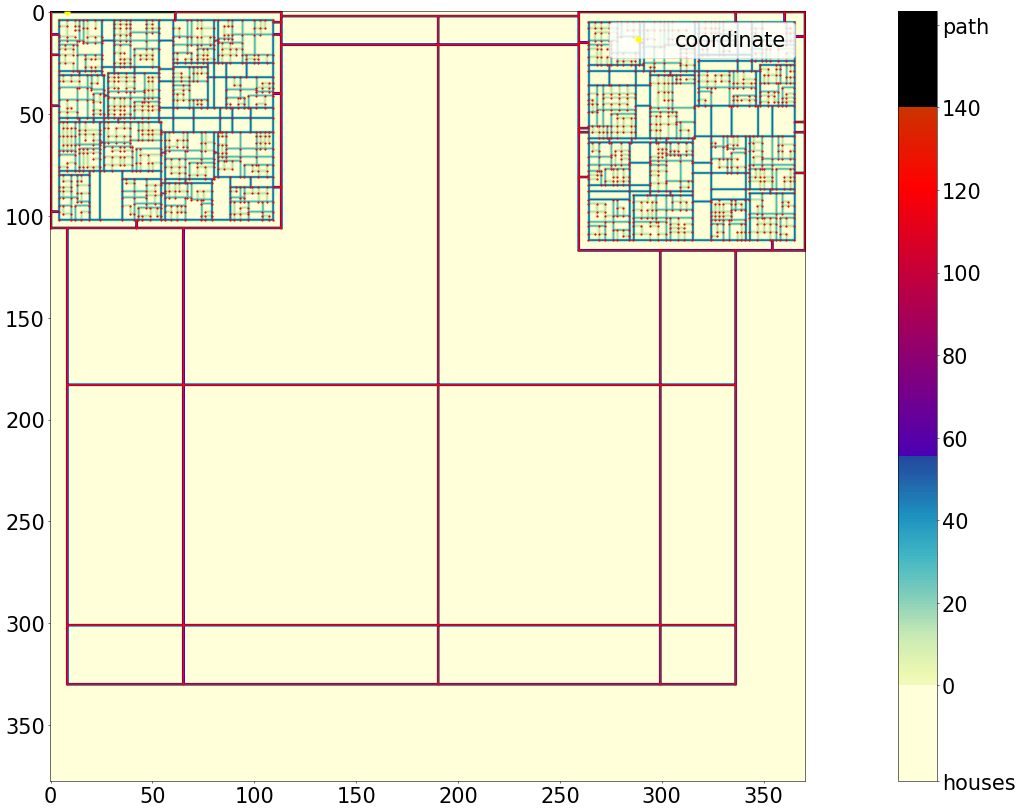

The coordinate is (2, 219), the closest nodes are [(2, 259), (2, 190)]


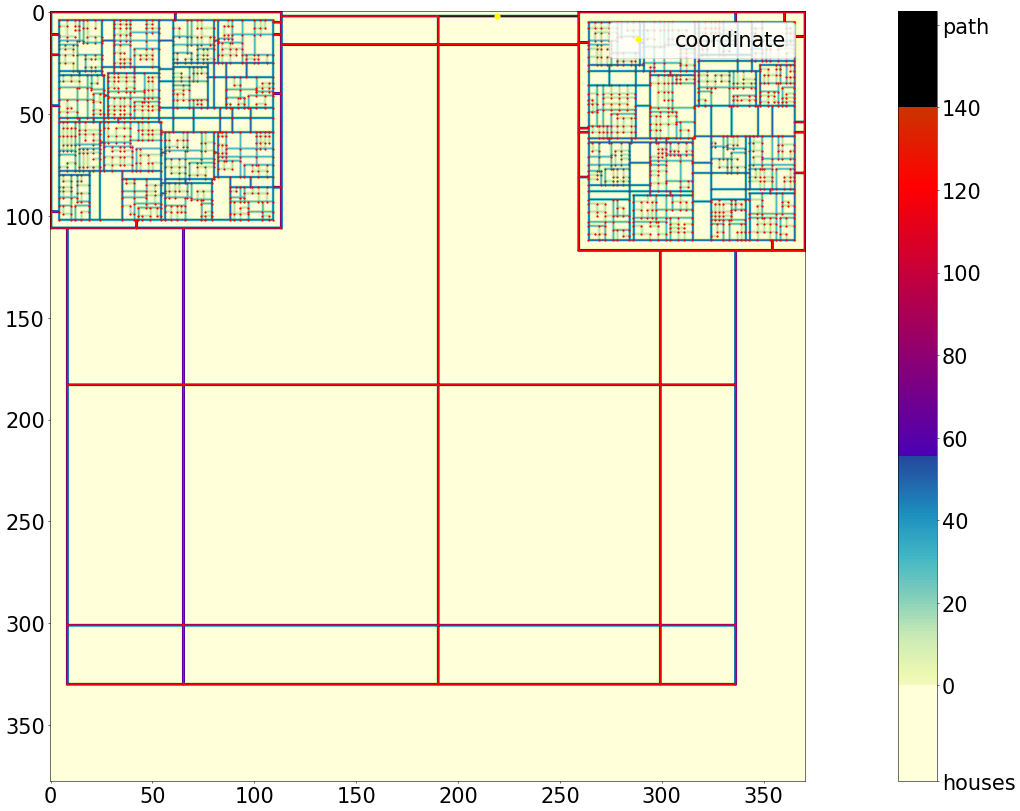

In [22]:
# If you put the map generated in a separate cell you can run multiple tests on the same map
map_ = Map(2, (1,3))

plt.matplotlib.rcParams['figure.dpi'] = max(50, map_.size ** 0.5 // 2)  # Number of pixels, therefore, the quality of the image. A large dpi is very slow.

graph = Graph(map_)
coordinate = map_.get_coordinate()

nodes = coordinate_to_node(map_, graph, coordinate)
print(f"the coordinate is {coordinate}, the closesest nodes are {nodes}")

graph.show_coordinates(color='r', size=2)
plt.plot(coordinate[1], coordinate[0], 'x', color="yellow", markersize=4, mew=8, label="coordinate")
plt.legend(loc='upper right')
map_.show(nodes, True)

# Further testings: For each 5 maps, 2 coordinates are generated and the closest nodes are shown
for i in range(1,6):
    map_ = Map(i, (1,3))
    graph = Graph(map_)
    for _ in range(2):
        coordinate = map_.get_coordinate()
        nodes = coordinate_to_node(map_, graph, coordinate)
        print(f"The coordinate is {coordinate}, the closest nodes are {nodes}")

        graph.show_coordinates(color='r', size=2)
        plt.plot(coordinate[1], coordinate[0], 'x', color="yellow", markersize=4, mew=8, label="coordinate")
        plt.legend(loc='upper right')
        map_.show(nodes, True)
        plt.show()


## 2.2 Hierarchical Graph Representations

***IMPORTANT NOTE: The algorithms in [2.2](#2.2-Hierarchical-Graph-Representations) and [2.3](#2.3a-Solving-the-Hierarchical-Graph-Representations) are more difficult to implement. If you describe and explain in your report how these algorithms should work but you do not implement them thus you skip to [3.0](#3.0-Fastest-Path-Between-Coordinates-(map-level-5)) then you can still get an 8.5. In other words, the following algorithms are designed to see if you can work with the ideas that you have learned in a new way and therefore make the difference between an 8.5 and 10.***

Let's start with some background information. While it is unknown exactly how Google Maps works, there are open-source algorithms that should be similar to what Google Maps does. Often these algorithms include a Hierarchical system, where some nodes are more important than others. This is essentially already what we done when we went from a grid to a graph. Here, we determined that some coordinates were less important than others. However, we could take it one step further, not all nodes are equally important. For example, in a level 5 map, the highway nodes are probably way more important than some nodes inside a neighborhood. Therefore, it does not make a lot of sense to explore every little street to find the fastest route. Just to give you an idea, there are multiple solutions to prevent this behavior such as determining important nodes and connecting those with a cost and path. For example in the image below, only (0,0) and (2,2) are connected with other roads therefore it would make sense to just have a connection from node (0,0) to (2,2) indicate with the red line. Now, we effectively made the graph even smaller and therefore even faster. You can repeat this step multiple times each time removing nodes from the graph making your search faster. 

<img src="hierarchical_nodes.png" alt="drawing" width="200"/>

However, determining which node should be more important is not easy beyond the coordinate-to-node step and therefore we will use another option which is sectioning off the map into multiple graphs. Each graph is connected to another graph with so-called port nodes and we assume that if you find the fastest path from one node to a port node or between port nodes and connect them you have the fastest path. In [2.3](#2.3a-Solving-the-Hierarchical-Graph-Representations) we will come back to this assumption. A logical way of splitting a level 5 map would be to make a graph for each city and a graph for the highways. Here, the port nodes are the highway exits. This makes the assumptions also more likely to be true as going from a city node to a highway node as fast as possible is probably the fastest path. Why this is the case? In summary, to solve the fastest path we need to solve the following fastest paths going from: coordinate A -> closest node A -> highway exit A -> highway exit B -> closest node B -> coordinate B. 

To make this possible, we need to make a highway graph and we need to make a separate graph for each city. One possibility would be to use our `Graph` class but use the argument `start` such that it works on a country (level 5) map for both the highways and individual cities. In `create_country_graphs`, you need to return the highway graph and a graph for each city.

***Hint: Use the methods and attributes of `map`***

[Go to map objects and methods](#Map-Objects-Methods-&-Attributes)

In [23]:
%%execwritefile assignment2_{group}_notebook.py 220 -a -s

def create_country_graphs(map_):
    """
    This function returns a list of all graphs of a country map, where the first graph is the highways and de rest are the cities.

    :param map_: The country map
    :type map_: Map
    :return: A list of graphs
    :rtype: list[Graph]
    """
    graphs = []
    highway = map_.get_highway_map()
    start_highway = map_.get_all_city_exits()[0]
    highway_graph = Graph(highway, start_highway)
    graphs.append(highway_graph)
    
    city_map = map_.get_city_map()
    # city corners is a list with the starting points of every city
    # its length is equal to the number of cities
    city_starts = map_.city_corners
    for city_index in range(len(city_starts)):
        # city_start = map_.get_coordinate_in_city(city_index)
        city_start = city_starts[city_index]
        city_graph = Graph(city_map, city_start)
        graphs.append(city_graph)

    return graphs
    


Appending to assignment2_3893995_4003748_notebook.py


### Test your code

Below, you can test your algorithm. Make sure that you test various road grids of a level 5 map and that your algorithm works for all of them. To give you a head start a very limited test is given. Here, each graph has different node colors and the port nodes (which are highway exits) have two colors green and a city graph node color.

In [24]:
# If you put the map generated in a separate cell you can run multiple tests on the same map
map_ = Map(5, (1,3), 2)


In [25]:
map_.city_corners

[(5, 5), (9, 268)]

3
2
[{(0, 0): [((0, 13), 13, 120.0), ((20, 0), 20, 120.0)], (0, 13): [((0, 112), 99, 120.0), ((4, 13), 4, 120.0), ((0, 0), 13, 120.0)], (0, 112): [((5, 112), 5, 120.0), ((0, 13), 99, 120.0)], (0, 259): [((0, 294), 35, 120.0), ((45, 259), 45, 120.0)], (0, 294): [((0, 320), 26, 120.0), ((8, 294), 8, 120.0), ((0, 259), 35, 120.0)], (0, 320): [((0, 387), 67, 120.0), ((8, 320), 8, 120.0), ((0, 294), 26, 120.0)], (0, 387): [((79, 387), 79, 120.0), ((0, 320), 67, 120.0)], (4, 13): [((0, 13), 4, 120.0)], (5, 108): [((5, 112), 4, 120.0)], (5, 112): [((45, 112), 40, 120.0), ((5, 108), 4, 120.0), ((0, 112), 5, 120.0)], (8, 294): [((0, 294), 8, 120.0)], (8, 320): [((0, 320), 8, 120.0)], (20, 0): [((20, 4), 4, 120.0), ((55, 0), 35, 120.0), ((0, 0), 20, 120.0)], (20, 4): [((20, 0), 4, 120.0)], (45, 112): [((45, 196), 84, 120.0), ((53, 112), 8, 120.0), ((5, 112), 40, 120.0)], (45, 196): [((45, 259), 63, 120.0), ((88, 196), 43, 120.0), ((45, 112), 84, 120.0)], (45, 259): [((88, 259), 43, 120.0), ((45,

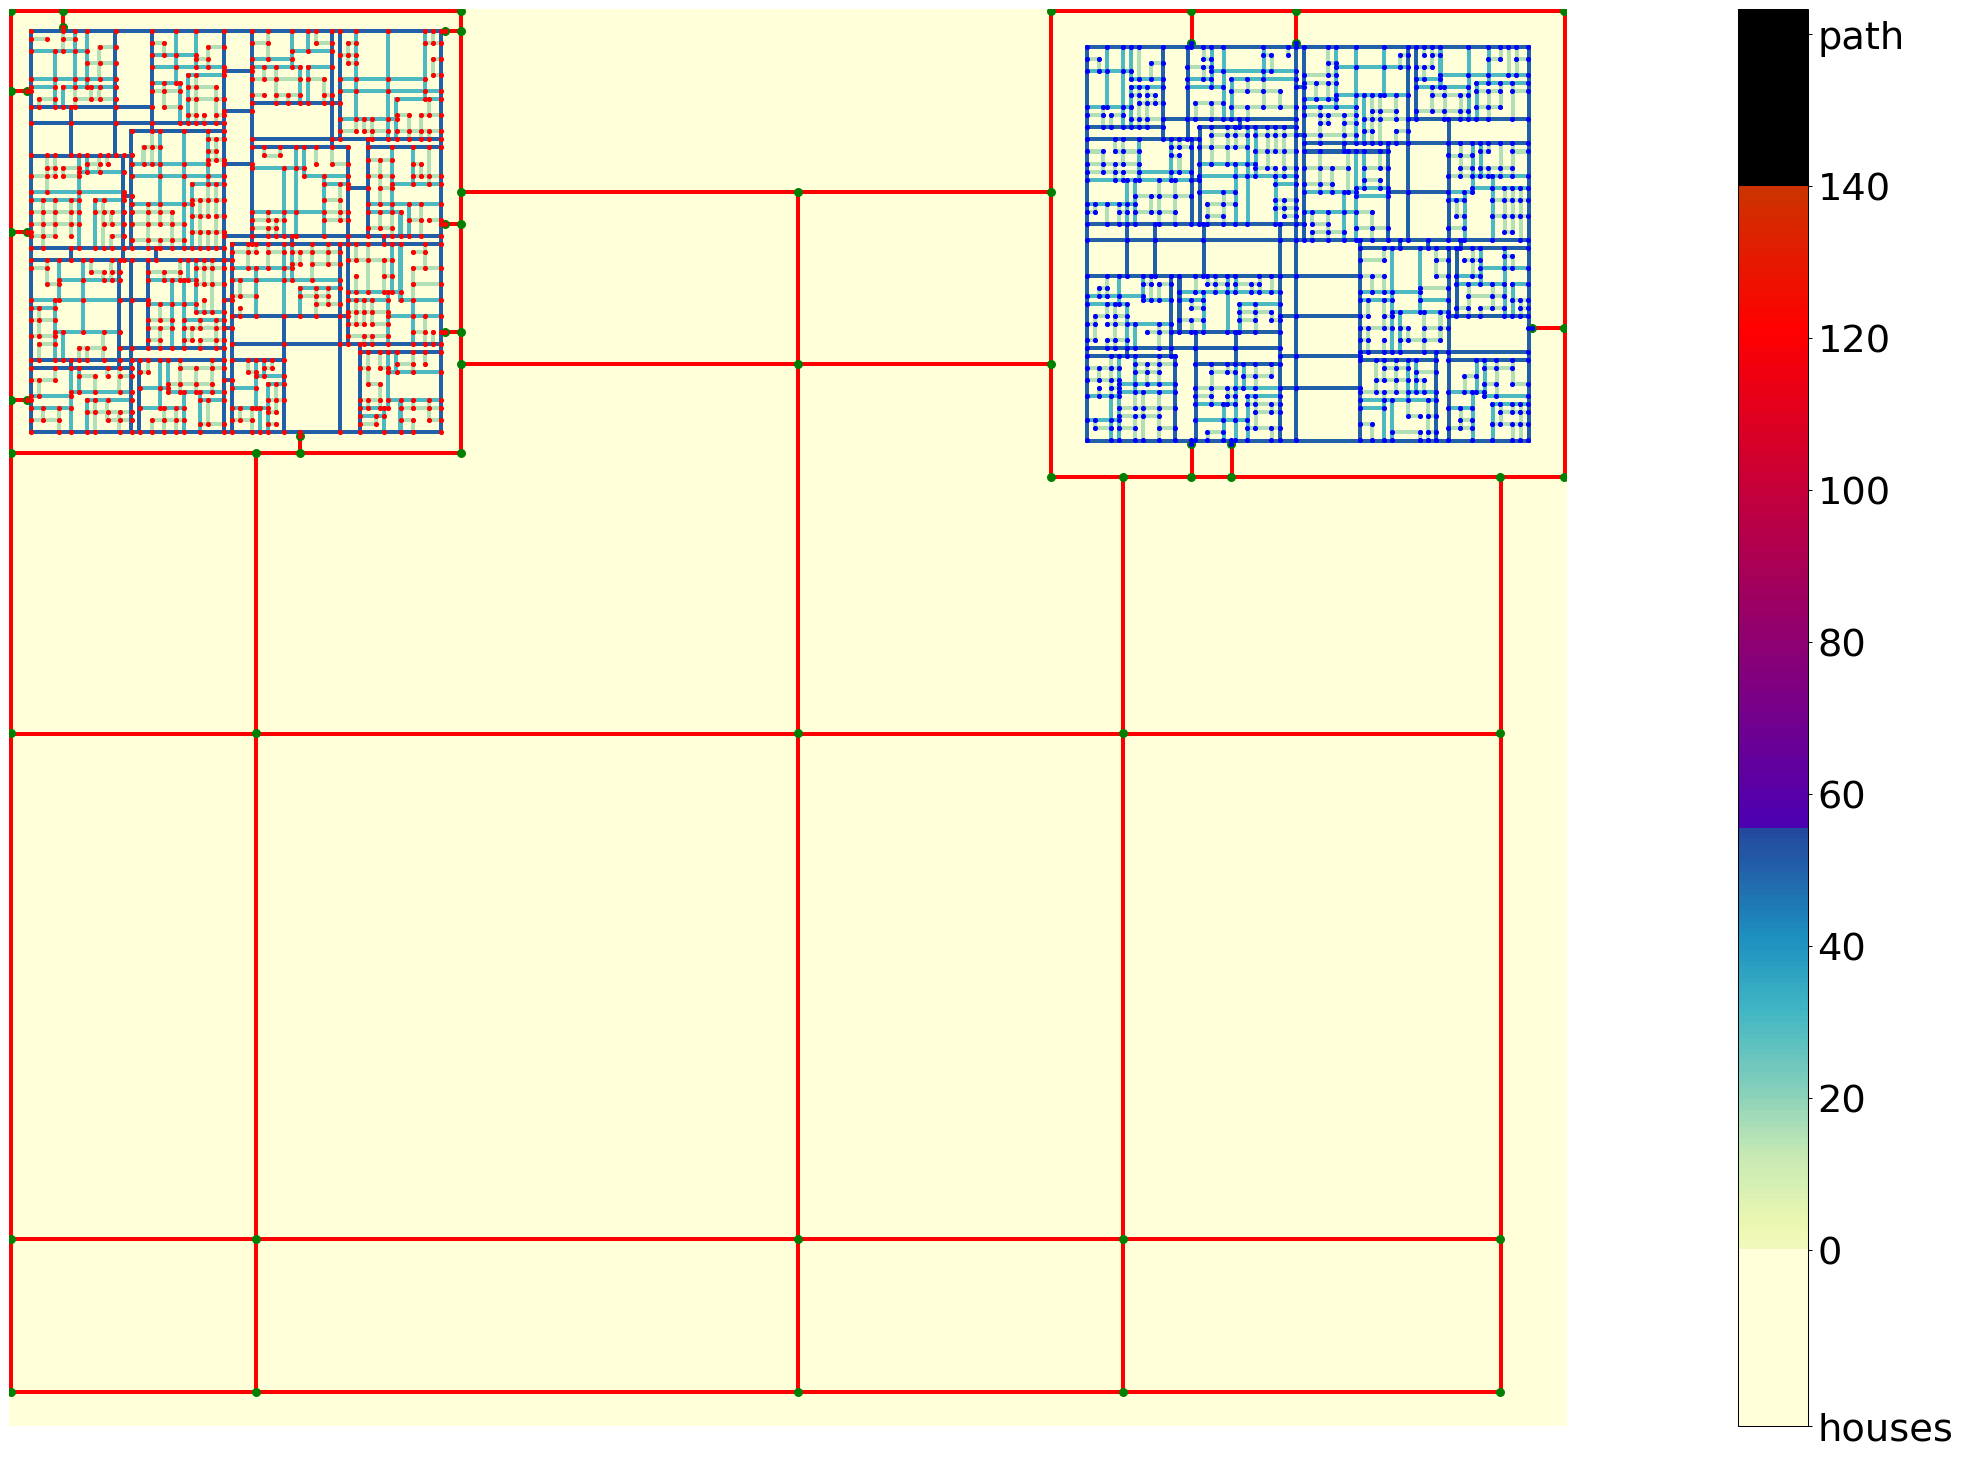

Graph list (one for highways and one for each city): [{(0, 0): [((0, 8), 8, 120.0), ((23, 0), 23, 120.0)], (0, 8): [((0, 44), 36, 120.0), ((6, 8), 6, 120.0), ((0, 0), 8, 120.0)], (0, 44): [((0, 71), 27, 120.0), ((6, 44), 6, 120.0), ((0, 8), 36, 120.0)], (0, 71): [((0, 118), 47, 120.0), ((6, 71), 6, 120.0), ((0, 44), 27, 120.0)], (0, 118): [((5, 118), 5, 120.0), ((0, 71), 47, 120.0)], (0, 259): [((0, 313), 54, 120.0), ((5, 259), 5, 120.0)], (0, 313): [((0, 341), 28, 120.0), ((3, 313), 3, 120.0), ((0, 259), 54, 120.0)], (0, 341): [((0, 366), 25, 120.0), ((3, 341), 3, 120.0), ((0, 313), 28, 120.0)], (0, 366): [((30, 366), 30, 120.0), ((0, 341), 25, 120.0)], (3, 313): [((0, 313), 3, 120.0)], (3, 341): [((0, 341), 3, 120.0)], (5, 118): [((5, 191), 73, 120.0), ((46, 118), 41, 120.0), ((0, 118), 5, 120.0)], (5, 191): [((5, 259), 68, 120.0), ((46, 191), 41, 120.0), ((5, 118), 73, 120.0)], (5, 259): [((41, 259), 36, 120.0), ((5, 191), 68, 120.0), ((0, 259), 5, 120.0)], (6, 8): [((0, 8), 6, 120.

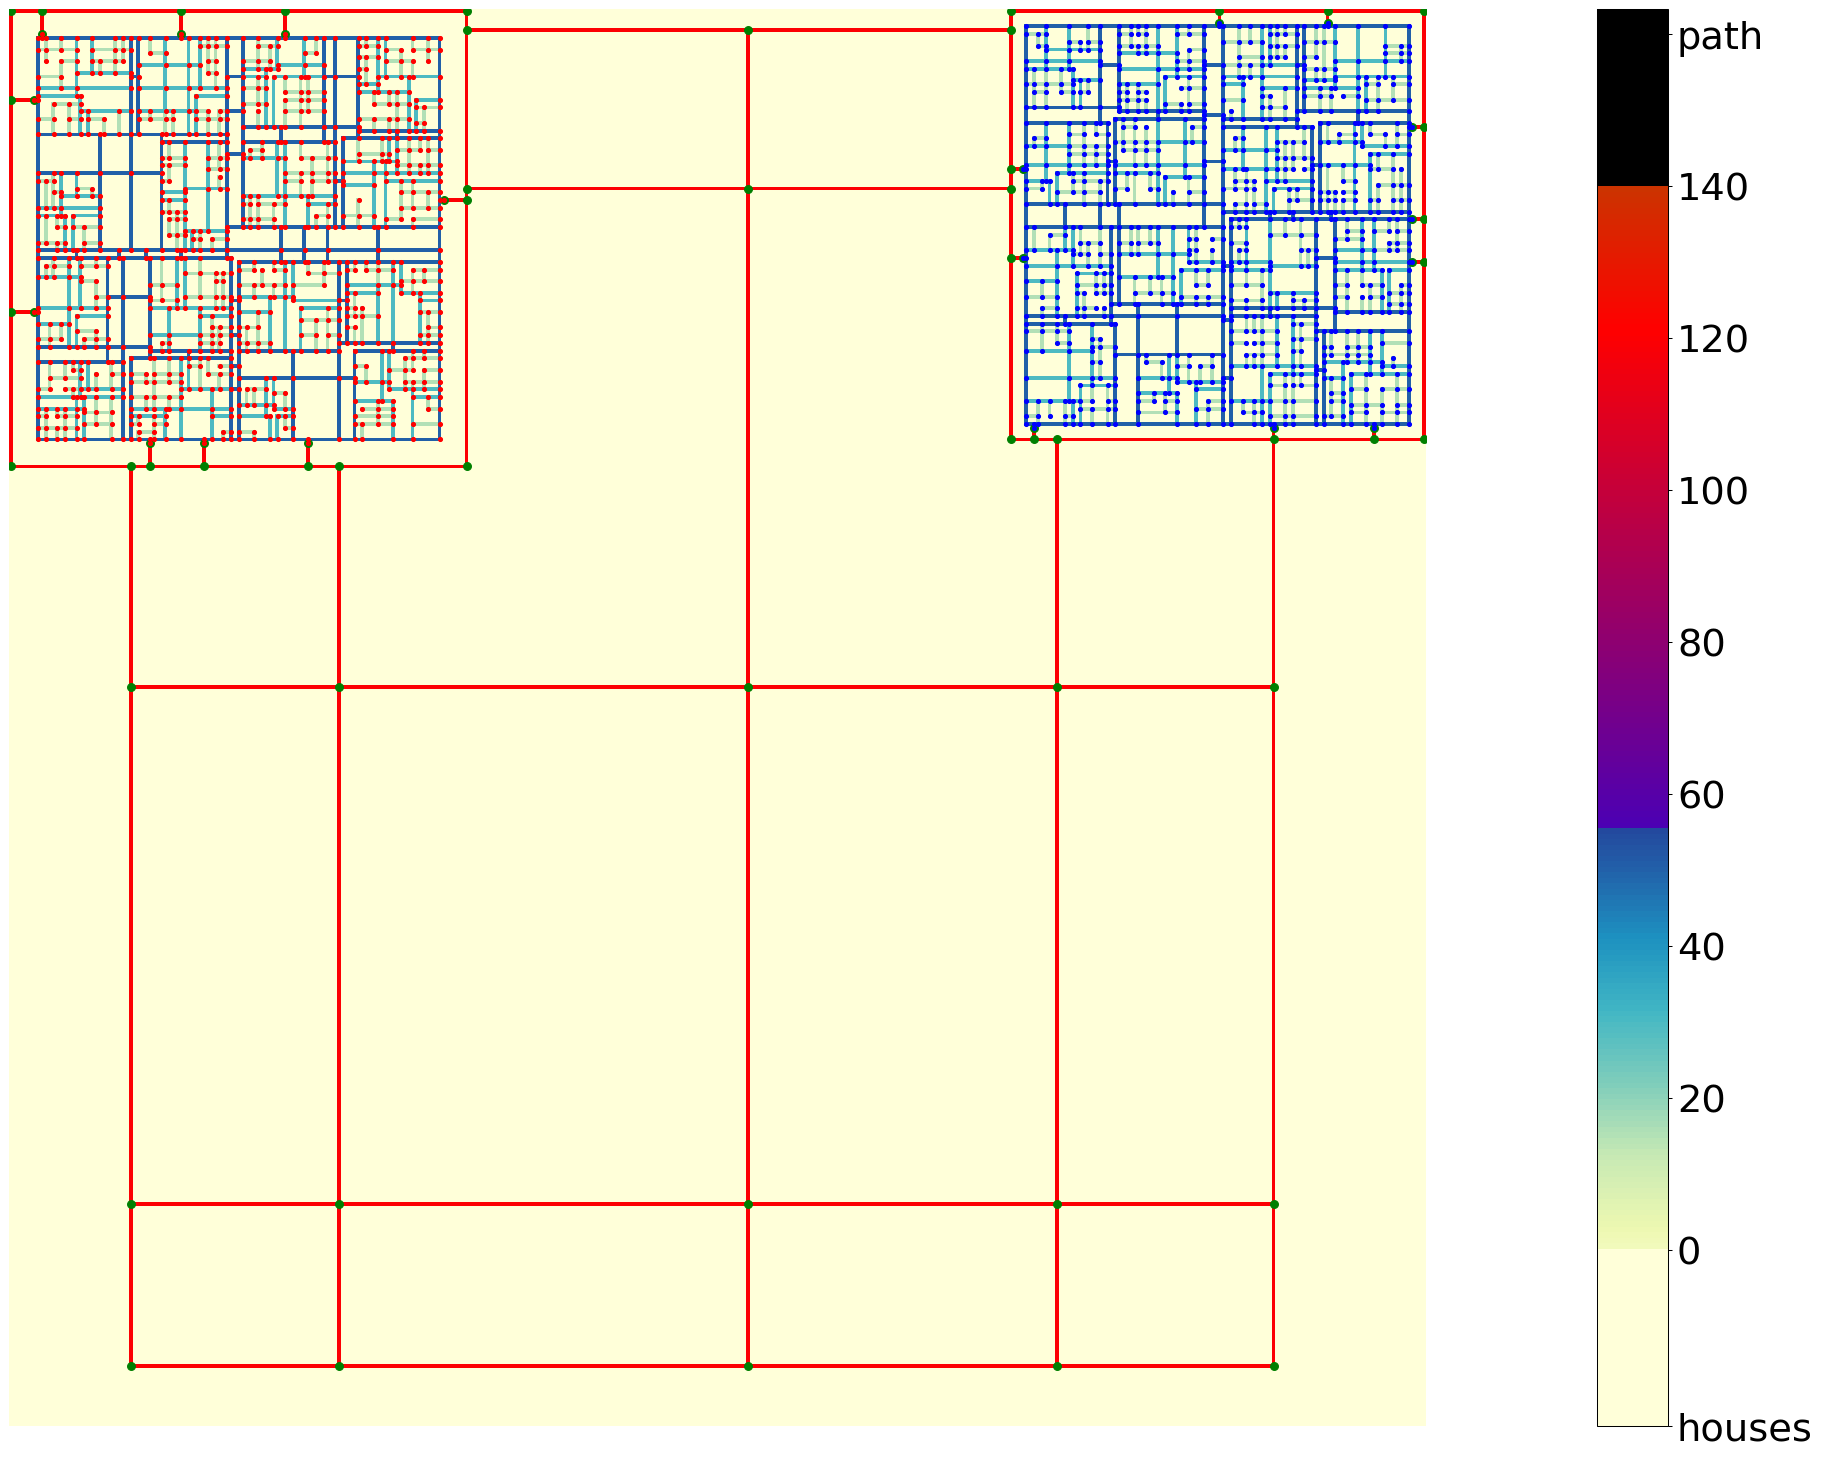

Highway map:
 [[120. 120. 120. ... 120. 120. 120.]
 [120.   0.   0. ...   0.   0. 120.]
 [120.   0.   0. ...   0.   0. 120.]
 ...
 [  0.   0.   0. ...   0.   0.   0.]
 [  0.   0.   0. ...   0.   0.   0.]
 [  0.   0.   0. ...   0.   0.   0.]]
City corner at: (7, 7)
City area around corner:
 [[50. 50. 50. 50. 50. 50. 50. 50. 50. 50.]
 [50.  0. 15.  0.  0.  0. 15.  0.  0.  0.]
 [50.  0. 15.  0.  0.  0. 15.  0.  0.  0.]
 [50. 15. 15. 15. 15. 15. 15. 15. 15. 15.]
 [50.  0. 15.  0.  0.  0.  0.  0.  0.  0.]
 [50.  0. 15.  0.  0.  0.  0.  0.  0.  0.]
 [50.  0. 15.  0.  0.  0. 15. 15. 15. 15.]
 [50.  0.  0.  0.  0.  0. 15.  0.  0.  0.]
 [50.  0.  0.  0.  0.  0. 15.  0.  0.  0.]
 [50.  0.  0.  0.  0.  0. 15.  0.  0.  0.]]
City corner at: (4, 263)
City area around corner:
 [[50. 50. 50. 50. 50. 50. 50. 50. 50. 50.]
 [50.  0.  0.  0.  0. 30.  0.  0.  0.  0.]
 [50. 15. 15. 15. 15. 30.  0.  0.  0.  0.]
 [50.  0.  0. 15.  0. 30.  0.  0.  0.  0.]
 [50.  0.  0. 15.  0. 30.  0.  0.  0.  0.]
 [50.  0.  0

In [26]:
plt.matplotlib.rcParams['figure.dpi'] = min(1000, max(50, map_.size ** 0.5 // 4))  # Number of pixels, therefore, the quality of the image. A large dpi is very slow.
# map_.show()
colors = ["g", "r", "b", "y", "m", "c"]
print(len(map_.city_grids))
print(len(map_.city_corners))
graph_list = create_country_graphs(map_)
print(graph_list)
for i, graph in enumerate(graph_list):
    print(i)
    graph.show_coordinates(color=colors[i], size=3 if i else 6)
print(len(graph_list))
# graph_list[0].show_edges(width=1, color='c')
map_.show()

# Further testings: For each 5 maps, the graphs are shown
map_ = Map(5, (1,3), 2)  # country with 2 cities

graph_list = create_country_graphs(map_)
print("Graph list (one for highways and one for each city):", graph_list)
colors = ["g", "r", "b", "y", "m", "c"]
for i, graph in enumerate(graph_list):
    print(f"Graph {i}:")
    graph.show_coordinates(color=colors[i % len(colors)], size=3 if i else 6)

map_.show()

highway_map = map_.get_highway_map().grid
print("Highway map:\n", highway_map)

for corner in map_.city_corners:
    print("City corner at:", corner)
    print("City area around corner:\n", map_.grid[corner[0]:corner[0]+10, corner[1]:corner[1]+10])

print("Exits:", map_.get_all_city_exits())


## 2.3a Solving the Hierarchical Graph Representations

***IMPORTANT NOTE: Again, [2.3a](#2.3a-Solving-the-Hierarchical-Graph-Representations) is a more difficult algorithm and you can skip it and implement [2.3b](#2.3b-Multiple-Destinations) and [3.0](#3.0-Fastest-Path-Between-Coordinates-(map-level-5)) using the multiple graphs but without solving the hierarchical graph representation. This would result in a maximum grade of a 9.5, if you describe the idea of this step correctly in your report, but without implementing it.***

At this point, we have everything to create the fastest path between two coordinates in different cities. However, there are instances where going from a coordinate A -> closest node A -> highway exit A -> highway exit B -> closest node B -> coordinate B is not the fastest path because the second fastest node A -> highway exit A leads to a much faster highway exit A -> highway exit B time. Therefore, making the found path suboptimal. The current approach where we divide the problem into smaller problems will never guarantee the fastest path unless we solve the hierarchical graph representation where we consider all port nodes. Below, you can find an image of an example where the port nodes are shown. However, to solve this graph we need to know the weight (cost) of each edge which can be found by applying BFS with a priority queue. However, while this would still be a bit faster than just searching from closest node A to closest node B in one go. We still need to find a lot of smaller paths as can be seen in the image below.

<img src="hierarchical_graph.png" alt="drawing" width="800"/>

However, We can explore the graph where we only calculate the fastest path between two connected nodes if it is needed. This can be done by not searching for all highway exits but only the $n$ fastest from both closest nodes at the same time. This solves our previous problem where the second nearest highway exit was the fastest route. Now, we have essentially created a tuning parameter between a fast search and a guaranteed optimal search. Think about what happens if n equals 1 or if n equals the number of highway exits.

We need to change three things compared to our previous `BFSSolverFastestPath`:
 - Our algorithm needs to accept multiple source nodes where each node has a travel time which is the time it takes to get to the source node (this can be zero).
 - Our algorithm needs to accept multiple destination nodes where each node has a travel time which is the time it takes to get from the destination node to somewhere else (this can be zero).
 - `find_path` needs to be updated to `find_n_paths`such that it takes into account the destination travel time but also return the $n$ best optimal paths.

This means that instead of starting with a history and queue of one node we start with multiple source nodes and we search for multiple destinations. Also, the start cost is not 0, but the cost so far to get there. Similarly, the total path cost for the path includes the cost of the destination node (which can be zero or the cost to get from this destination node to another node).

Note, that we already use inheritance to copy-paste all the code from `BFSSolverFastestPath` to `BFSSolverMultipleFastestPaths`. Also, `found_destinations` are now the destinations found by the algorithm, and `destination_nodes` is the input argument containing all destinations. This is different compared to `destinations` as it also contains the travel time for each destination. We gave you the three methods which we think should be adjusted. However, you are free to overwrite any other previous methods as well.

We included an `__init__` To make different versions of the `BFSSolverMultipleFastestPaths` where the number of paths found is different.

***You can use [2.3b](#2.3b-Multiple-Destinations) to practice because in [2.3b](#2.3b-Multiple-Destinations) you only need to search for multiple destination nodes which is a separate problem from starting with multiple nodes or finding the $n$ optimal paths.***

In [27]:
%%execwritefile assignment2_{group}_notebook.py 230 -a -s 

class BFSSolverMultipleFastestPaths(BFSSolverFastestPath):
    """
    A class instance should at least contain the following attributes after being called:
        :param priorityqueue: A priority queue that contains all the nodes that need to be visited including the time it takes to reach these nodes.
        :type priorityqueue: list[tuple[tuple[int], float]]
        :param history: A dictionary containing the nodes that are visited and as values the node that leads to this node including the time it takes from the start node.
        :type history: dict[tuple[int], tuple[tuple[int], float]]
        :param found_destinations: The destinations already found with Dijkstra.
        :type found_destinations: list[tuple[int]]
    """
    def __init__(self, find_at_most=3):
        """
        This init makes it possible to make a different Dijkstra algorithm 
        that find more or less destination nodes before it stops searching.

        :param find_at_most: The number of found destination nodes before the algorithm stops
        :type find_at_most: int
        """
        self.find_at_most = find_at_most
    
    def __call__(self, graph, sources, destinations, vehicle_speed):      
        """
        This method gives the top three fastest routes through the grid from any of the sources to any of the destinations.
        You start at the sources and the algorithm ends if you reach enough destinations, both nodes should be included in the path.
        A route consists of a list of nodes (which are coordinates).

        :param graph: The graph that represents the map.
        :type graph: Graph
        :param sources: The nodes where the path starts and the time it took to get here.
        :type sources: list[tuple[tuple[int], float]]
        :param destinations: The nodes where the path ends and the time it took to get here.
        :type destinations: list[tuple[tuple[int], float]]
        :param vehicle_speed: The maximum speed of the vehicle.
        :type vehicle_speed: float
        :return: A list of the n fastest paths and time they take, sorted from fastest to slowest 
        :rtype: list[tuple[path, float]], where path is a fictional data type consisting of a list[tuple[int]]
        """       
        self.priorityqueue = sorted(sources, key=lambda x:x[1])
        self.history = {s: (None, t) for s, t in sources}
        
        self.destinations = destinations
        self.destination_nodes = [dest[0] for dest in destinations]
        self.found_destinations = []
        self.graph = graph
        self.sources = sources
        self.vehicle_speed = vehicle_speed
        self.main_loop()
        return self.find_n_paths()


    def find_n_paths(self):
        """
        This method needs to find the top `n` fastest paths between any source node and any destination node.
        This does not mean that each source node has to be in a path nor that each destination node needs to be in a path.

        Hint1: The fastest path is stored in each node by linking to the previous node. 
               Therefore, if you start searching from a destination node,
               you always find the optimal path from that destination node.
               This is similar if you only had one destination node.         

        :return: A list of the n fastest paths and time they take, sorted from fastest to slowest 
        :rtype: list[tuple[path, float]], where path is a fictional data type consisting of a list[tuple[int]]
        """
        # return [(start[0], end) for end, start in self.history.items() if start[0] is not None]
        paths = []
        for destination in self.found_destinations:
            current = destination
            path = []
            time = self.history[current][1]
            while current:
                path.append(current)
                new = self.history[current][0]
                current = new
            paths.append((path, time))
        
        return sorted(paths, key=lambda x: x[1])
            
        
    def base_case(self, node):
        """
        This method checks if the base case is reached and
        updates self.found_destinations

        :param node: The current node
        :type node: tuple[int]
        :return: Returns True if the base case is reached.
        :rtype: bool
        """
        if node in self.destination_nodes:
            self.found_destinations.append(node)
            
        if len(self.found_destinations) == len(self.destination_nodes):
            return True
        return False

Appending to assignment2_3893995_4003748_notebook.py


### Practice With BFSSolverMultipleFastestPaths Before 3.0

Here you can make a test where you can practice connecting a node to the highway or finding paths between two ringways (the highway exits of two different cities) as suggested in test your code above. In question [3.0](#3.0-Fastest-Path-Between-Coordinates-(map-level-5)) you are tasked to connect two nodes using highway exits. Here, is a good place to practice how to do the substeps needed for [3.0](#3.0-Fastest-Path-Between-Coordinates-(map-level-5)). Note, that this exercise has a lot in common with lab 8 exercises 3.0 and 3.1.

In [28]:
# If you put the map generated in a separate cell you can run multiple tests on the same map
map_ = Map(4, (1,3))

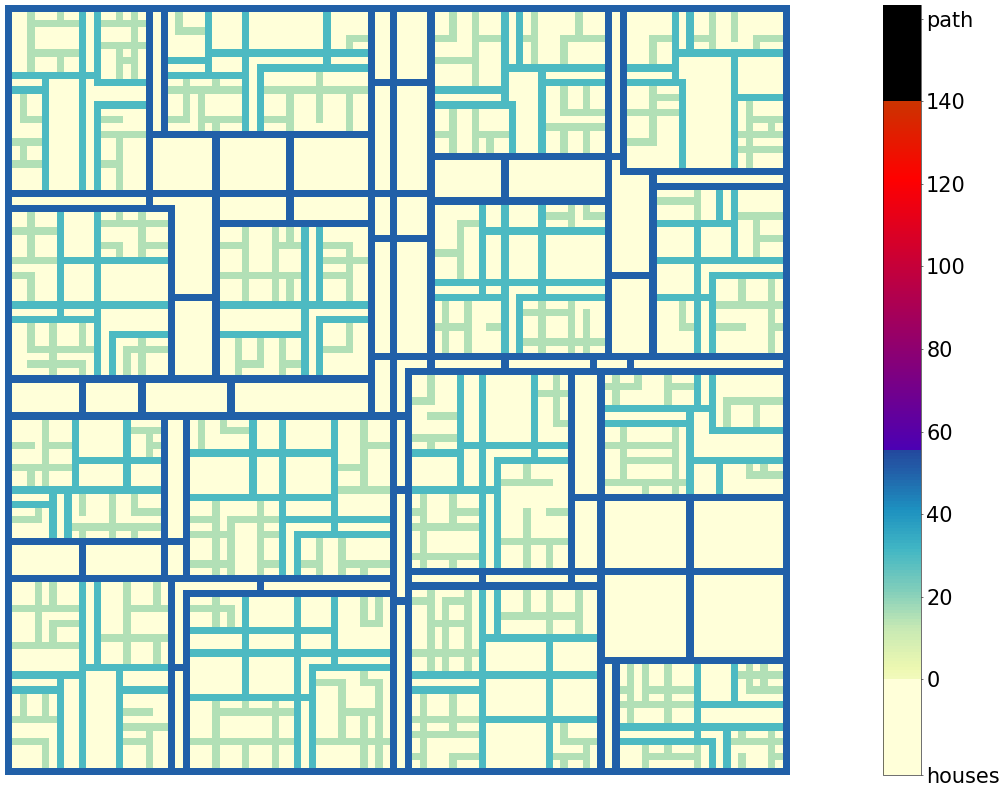

[((90, 0), 0), ((43, 105), 0), ((17, 103), 0)]
The estimate travel time for the path is: 1.8000000000000007
[(90, 0), (86, 0), (81, 0), (77, 0), (72, 0), (69, 0), (67, 0), (65, 0), (62, 0), (59, 0), (55, 0), (50, 0), (42, 0), (40, 0), (36, 0), (34, 0), (30, 0), (27, 0), (25, 0), (21, 0), (18, 0), (11, 0), (9, 0), (0, 0)]


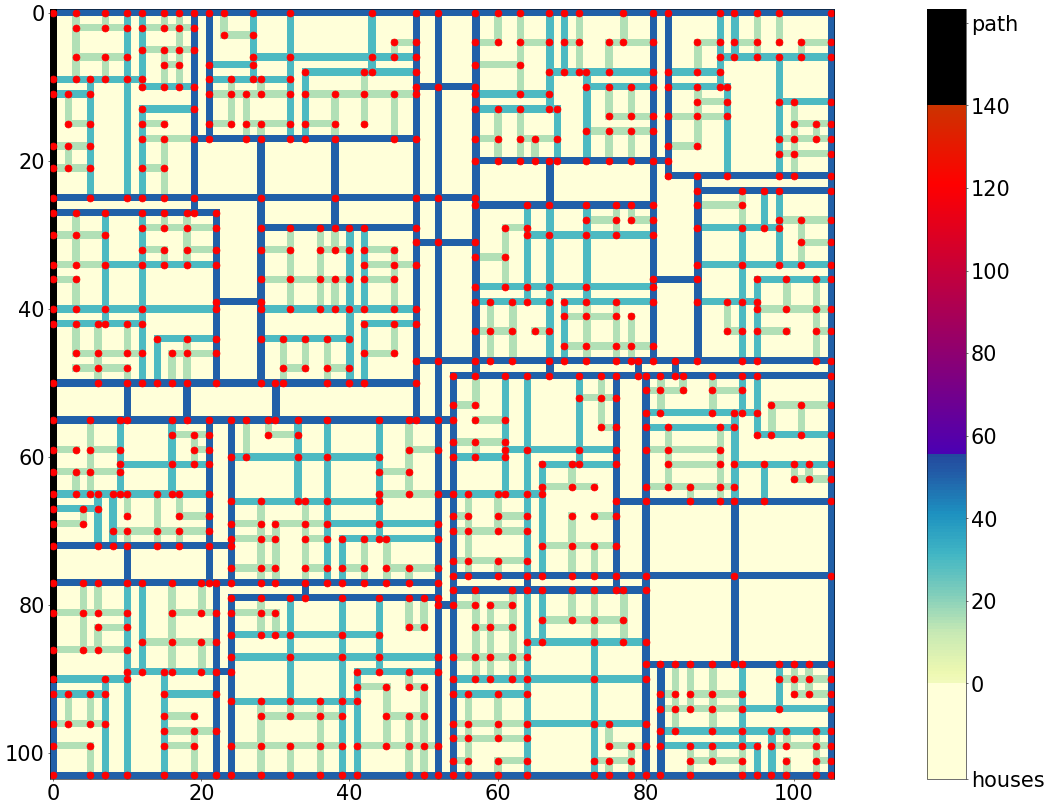

The estimate travel time for the path is: 3.346666666666668
[(17, 103), (17, 100), (19, 100), (22, 100), (22, 98), (22, 91), (22, 87), (22, 83), (20, 83), (20, 81), (26, 81), (26, 78), (26, 76), (26, 72), (26, 67), (26, 64), (26, 57), (25, 57), (25, 52), (25, 49), (25, 38), (25, 28), (25, 19), (25, 15), (25, 12), (25, 10), (9, 10), (9, 7), (9, 5), (9, 3), (9, 0), (0, 0)]


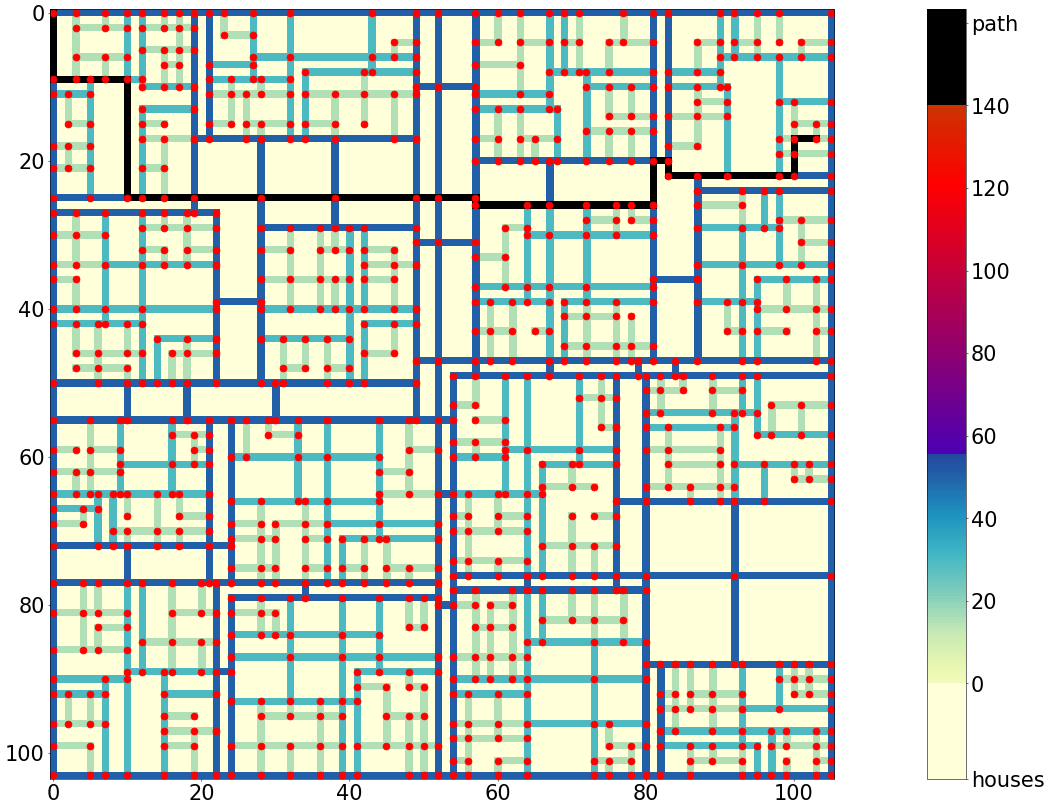

The estimate travel time for the path is: 3.4266666666666676
[(43, 105), (47, 105), (47, 103), (47, 95), (47, 93), (47, 87), (39, 87), (36, 87), (36, 81), (30, 81), (30, 76), (30, 72), (30, 67), (26, 67), (26, 64), (26, 57), (25, 57), (25, 52), (25, 49), (25, 38), (25, 28), (25, 19), (25, 15), (25, 12), (25, 10), (9, 10), (9, 7), (9, 5), (9, 3), (9, 0), (0, 0)]


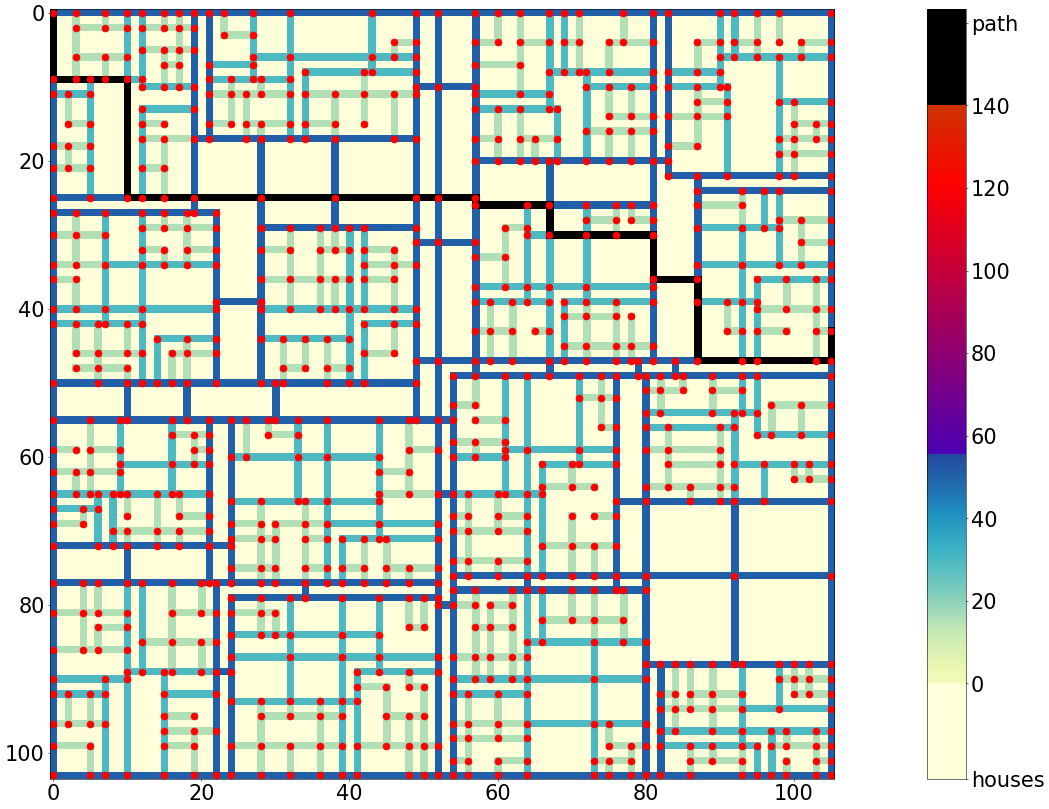

In [29]:
plt.matplotlib.rcParams['figure.dpi'] = min(1000, max(50, map_.size ** 0.5 // 4))  # Number of pixels, therefore, the quality of the image. A large dpi is very slow.

graph = Graph(map_)
start = [((0,0), 0)]
map_.show()
ends = [(graph.get_random_node(), 0), (graph.get_random_node(), 0), (graph.get_random_node(), 0)]
vehicle_speed = 180

print(ends)
paths = BFSSolverMultipleFastestPaths()(graph, start, ends, vehicle_speed)
for path, time in paths:
    print(f"The estimate travel time for the path is: {time}")
    print(path)
    graph.show_coordinates(color='r', size=10)
    map_.show(path, True)

## 2.3b Multiple Destinations

***IMPORTANT NOTE: This question is only a replacement for [2.3a](#2.3a-Solving-the-Hierarchical-Graph-Representations). So skip it if you did [2.3a](#2.3a-Solving-the-Hierarchical-Graph-Representations)!***

Our previous `BFSSolverFastestPath` could only solve a path if the source and destination node were known. However, we do not know what the closest highway exit is when we try to find the fastest path between the closest node and the nearest highway exit. This can be solved by just giving multiple destination nodes and the destination node you find is the closest and therefore you can stop. Below, you need to program this functionality.

Note, that we already use inheritance to copy-paste all the code from `BFSSolverFastestPath` to `BFSSolverFastestPathMD`. Also, `destination` is now the destination found by the algorithm, and `destinations` is the input argument containing all destinations. We gave you the two methods which we think should be adjusted. However, you are free to overwrite any other previous methods as well.

In [ ]:
%%execwritefile assignment2_{group}_notebook.py 235 -a -s 

class BFSSolverFastestPathMD(BFSSolverFastestPath):
    def __call__(self, graph, source, destinations, vehicle_speed):      
        """
        This method is functionally no different than the call method of BFSSolverFastestPath
        except for what `destination` is.

        See for an explanation of all arguments `BFSSolverFastestPath`.
        
        :param destinations: The nodes where the path ends.
        :type destinations: list[tuple[int]]
        """
        self.priorityqueue = [(source, 0)]
        self.history = {source: (None, 0)}
        self.destinations = destinations
        self.destination = None
        self.vehicle_speed = vehicle_speed

        raise NotImplementedError("Please complete this method")       

    def base_case(self, node):
        """
        This method checks if the base case is reached.

        :param node: The current node
        :type node: tuple[int]
        :return: returns True if the base case is reached.
        :rtype: bool
        """
        raise NotImplementedError("Please complete this method")

### Test your code

Below, you can test your algorithm. Make sure that you test various road grids and that your algorithm works for all of them. The test that is given contains one start node and three random destination nodes. Try to make a test, where you choose one start node inside a city and as destination nodes the city highway exits. Of course, you need to use the level 5 map to do this.

In [ ]:
# If you put the map generated in a separate cell you can run multiple tests on the same map
map_ = Map(2, (1,3))

In [ ]:
plt.matplotlib.rcParams['figure.dpi'] = min(1000, max(50, map_.size ** 0.5 // 4))  # Number of pixels, therefore, the quality of the image. A large dpi is very slow.

graph = Graph(map_)

start = (0,0)
end = [graph.get_random_node(), graph.get_random_node(), graph.get_random_node()]
print(end)
vehicle_speed = 180

path, time = BFSSolverFastestPathMD()(graph, start, end, vehicle_speed)
print(f"The estimate travel time for the path is: {time}")
graph.show_coordinates(color='r', size=10)
plt.plot([y for _,y in end], [x for x,_ in end], 'x', color="yellow", markersize=20, mew=8, label="destinations")
plt.legend(loc='upper right')
map_.show(path, True)


## 3.0 Fastest Path Between Coordinates (map level 5)

The final exercise in this assignment is to combine the algorithms implemented so far to make a path from one coordinate to another where we go from a coordinate A -> closest node A -> highway exit A -> highway exit B -> closest node B -> coordinate B. In this exercise, you should not implement any new path-finding algorithms. Below you can find some hints and rules:
- The algorithm you need to write has to work only on level 5 maps.
- You only need to find the fastest path, ***not*** the shortest path.
- You do not have to find the path in the order given above. For example, you can first find the path from coordinate A to closest node A and the path from coordinate B to closest node B before finding a path between highway exits.
- Start with finding in which city each coordinate is.
- You are allowed to use helper functions. For example, a function to calculate the time it takes to travel between two nodes.
- When searching for the nearest exits assume that all exits are equally good.
- If two nodes are in the same city, you need to check if using the highway is faster. This means, however, that you do not have to use them.
- If you did [2.2](#2.2-Hierarchical-Graph-Representations), you need to use the different graphs. **You are never allowed to use a BFS solver on the whole map**, not even as a side/sub-step.
- As explained in [2.3a](#2.3a-Solving-the-Hierarchical-Graph-Representations), just using one outcome of the previous path-finding algorithm can easily lead to a sub-optimal path. Therefore, to get to all points, you need to use the top $n$ (if possible) best path destinations from the previous algorithm as start destinations in the next path-finding algorithm.

Just as a summary here are the classes and functions you implemented (that could be useful):
- `Graph` class [link](#1.1.0-Making-Graph-Nodes-from-a-Map)
- `coordinate_to_node` function [link](#2.1-From-Coordinate-to-Node)
- `create_country_graphs` function [link](#2.2-Hierarchical-Graph-Representations)
- `BFSSolverFastestPath` class [link](#2.0-Fastest-Path-with-BFS)
- `BFSSolverFastestPathMD` class [link](#2.3b-Multiple-Destinations)
- `BFSSolverMultipleFastestPaths` class [link](#2.3a-Solving-the-Hierarchical-Graph-Representations)

[Go to map objects and methods](#Map-Objects-Methods-&-Attributes)

In [ ]:
%%execwritefile assignment2_{group}_notebook.py 300 -a -s 

def path_length(coordinate, closest_nodes, map_, vehicle_speed):
    return [(node, (abs(node[0] - coordinate[0]) + abs(node[1] - coordinate[1])) / min(vehicle_speed, map_[coordinate])) for node in closest_nodes] 

def find_path(coordinate_A, coordinate_B, map_, vehicle_speed, find_at_most=3):
    """
    Find the optimal path according to the divide and conquer strategy from coordinate A to coordinate B.

    See hints and rules above on how to do this.

    :param coordinate_A: The start coordinate
    :type coordinate_A: tuple[int]
    :param coordinate_B: The end coordinate
    :type coordinate_B: tuple[int]
    :param map_: The map on which the path needs to be found
    :type map_: Map
    :param vehicle_speed: The maximum vehicle speed
    :type vehicle_speed: float
    :param find_at_most: The number of routes to find for each path finding algorithm, defaults to 3. 
                         Note, that this is only needed if you did 2.3.
    :type find_at_most: int, optional
    :return: The path between coordinate_A and coordinate_B. Also, return the cost.
    :rtype: list[tuple[int]], float
    """
    raise NotImplementedError("Please complete this method")

### Test your code

Below, you can test your algorithm. Make sure that you test various road grids and that your algorithm works for all of them. To give you a head start a very limited test is given. For example, make sure that you test how your algorithm works if both coordinates are in the same city.

In [ ]:
# If you put the map generated in a separate cell you can run multiple tests on the same map
map_ = Map(5, (2, 4), 2) 

In [ ]:
plt.matplotlib.rcParams['figure.dpi'] = min(1000, max(50, map_.size ** 0.5 // 4))  # Number of pixels, therefore, the quality of the image. A large dpi is very slow.

start = map_.get_coordinate_in_city(RNG.integers(len(map_.city_grids)-1))
end = map_.get_coordinate_in_city(RNG.integers(len(map_.city_grids)-1))
vehicle_speed = 180

path, time = find_path(start, end, map_, vehicle_speed, 3)
print(f"The estimate travel time for the path is: {time}")
# uncomment to see all nodes
# graph = Graph(map_)
# graph.show_coordinates(color='g', size=2)
map_.show(path)

# UNITTESTS

During this assignment, we copied all your code to the following **.py** file **"assignment2_{group}_notebook.py"**. You also tested your code along the way. However, it is possible that there are still a few errors. Therefore, it is good to run some unittest when you complete all coding. This gives you an extra chance to spot mistakes. Here, we added some unittest for you to use. Note, that they are not ***complete*** and that they are merely an indication if you are above or below a 6 (still no guarantee). In this assignment, there are fewer unittest and the best unittest are checking in the images if your algorithm works. Try, for each algorithm different inputs and check if the route changing how you expect it to change.

From this point onwards we strongly advise renaming the **"assignment2_{group}_notebook.py"** file to the correct file name that you need to hand in **"assignment2_{group}.py"**. Now, you can adjust the **"assignment2_{group}.py"** file without the risk of overwriting it when you run the notebook again. This also enables the possibility to run the unittests. Note, that from now on you are done programming in the notebook and you need to adjust the **.py** file to fix bugs. To run the unittests go to the **"unit_test.py"** file and run the file in either PyCharm, VSCode, or a terminal. You can run it in a terminal using the following command: `python -m unittest --verbose unit_test.py`. `--verbose` is optional but gives you more details about which tests fail and which succeed.

You are allowed to add your own unittests.

***Do not forget to write Your Report! Instruction can be found below***

# Report

Write a report in LATEX(at most 3 pages) using the provided template (see Brightspace), addressing the following points/research questions:
 - Introduction: Describe the problem. Describe a state and action explicitly in the context of this problem.
 - A (concise) description of the methods you implemented and why you need a priority queue for the BFS on graphs to make the algorithm work compared to BFS for the floodfill algorithm that does not use a priority queue.
 - Hypothesize about which algorithm is faster and what to possible downsides are of each algorithm.
 - A small experiment in which you compare (a) the exhaustive approach, as well as (b) the greedy approach, and show over several graphs of increasing size the best-found solution as well as the amount of time needed to come to a solution. You can use the module time (time.time()) to test how long each algorithm takes. However, make sure you do not have any other processes actively running in the background. A better way is using the module timeit for example timeit.repeat(). However, this is a bit more difficult to get working.
 - Alternatively, if you do not implement 2.2 and 2.3 find a paper that uses some form of hierarchical graphs to solve a path-finding problem and give a small summary of their findings, including what they test, a general explanation how their algorithm works, and their conclusions.
 - Summary and Discussion. What was the goal of the assignment? What have you done and observed? (think about the performance of the algorithms, as well as a reflection on how that relates to what you would have expected). Do not write about your personal experience and stories. Keep it scientific and simply summarize the report, making observations about the algorithms.

## Work distribution

At the end of the report, include a distribution of the work: who did what? By default, we
give both group members the same grade, but in some extreme cases, we will adjust the grades according to the workload. The work distribution does not count towards the page limit.

# Submission

Submit your assignment through Brightspace by submitting the following files:
 - report.pdf (the report)
 - assignment2_{groupname}.py (your solution code), the groupname should be a string with the following format f"{studentnumber1}_{studentnumber2}". This name should not include "notebook" or "backup"!
 - assignment2.ipynb (backup if something goes wrong)
   
The deadline for this assignment is Wednesday 29 May 2023, 23:59 CET.